In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import seaborn as sns
import cobra
import scipy.stats as st
import scipy
sys.path.append('../../code/')
import leakage

In [29]:
folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-UniversitédeLausanne/UNIL/leakage/experimental work/sintef_sept_23/exometabolome')

In [30]:
fn = folder / 'SM_Quantitative_Results.xlsx'
mapping_fn = folder / 'met_to_bigg.csv'
od_fn = folder / '..' / 'REL-F-U37-23_OD_TV.xlsx'

## Read mapping

In [31]:
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

In [97]:
mapping_dict

{'SEBACOYL-L-CARNITINE (C10-DC)': nan,
 'DEOXYCARNITINE (DEOXY-C0)': nan,
 'GLUTARYLCARNITINE (C5-DC)': nan,
 'ALPHA-AMINOBUTYRATE': nan,
 'CREATINE': nan,
 'ALPHA-AMINOADIPATE': nan,
 'CIS-ACONITATE': 'acon_C',
 'CITRATE': 'cit',
 'HEXOSES including Glucose and Fructose': 'fru',
 'GLUTARATE': nan,
 'ISOCITRATE': 'icit',
 'LACTATE': 'lac__L',
 'GLUTAMATE': 'glu__L',
 'MALATE': 'mal__L',
 'NAD': 'nad',
 'SUCCINATE': 'succ',
 'TRANS-ACONITATE': 'acon_T',
 'ASPARAGINE': 'asn__L',
 'ASPARTATE': 'asp__L',
 'BETA-ALANINE': 'ala_B',
 'GAMMA-AMINOBUTYRATE': '4abut',
 'GLUTAMINE': 'gln__L',
 'GLYCINE': 'gly',
 'ISOLEUCINE': 'ile__L',
 'LEUCINE': 'leu__L',
 'LYSINE': 'lys__L',
 'METHIONINE': 'met__L',
 'PHENYLALANINE': 'phe__L',
 'PIPECOLIC ACID': nan,
 'PROLINE': 'pro__L',
 'SERINE': 'ser__L',
 'TYROSINE': 'tyr__L',
 'VALINE': 'val__L',
 'ALANINE': 'ala__L',
 'PYRUVATE': 'pyr'}

## Read OD and convert to biomass

In [32]:
od_df = pd.read_excel(od_fn, skiprows=2, nrows=21)
od_df.drop(index = 0, inplace=True)

In [33]:
rel_to_info = {
    'REL01': {'M': 'M1', 'CS': 'Galactose'},
    'REL02': {'M': 'M2', 'CS': 'Galactose'},
    'REL03': {'M': 'M3', 'CS': 'Galactose'},
    'REL04': {'M': 'M5', 'CS': 'L-malate'},
    'REL05': {'M': 'M6', 'CS': 'L-malate'},
    'REL06': {'M': 'M7', 'CS': 'L-malate'},
    'REL07': {'M': 'M9', 'CS': 'L-alanine'},
    'REL08': {'M': 'M10', 'CS': 'L-alanine'},
    'REL09': {'M': 'M11', 'CS': 'L-alanine'}
    }
M_to_rel = {dic['M']:rel for rel, dic in rel_to_info.items()}


In [34]:
od_df.rename(columns={'Unnamed: 0': 'Timestamp', 'Unnamed: 1': 'Time', 'Unnamed: 2': 'Hours'}, inplace=True)

In [35]:
od_df

Timestamp                 Time Hours  REL01  REL02  REL03  \
1   2023-09-13 00:00:00             09:00:00     0  0.044  0.044  0.015   
2   2023-09-13 00:00:00             11:00:00   2.0   0.09   0.09   0.07   
3   2023-09-13 00:00:00             13:00:00   4.0   0.17   0.17   0.12   
4   2023-09-13 00:00:00             15:00:00     6   0.31   0.32    0.2   
5   2023-09-13 00:00:00             17:00:00   8.0   0.58   0.58   0.45   
6   2023-09-13 00:00:00             18:15:00  9.25    NaN    NaN    NaN   
7   2023-09-13 00:00:00             19:00:00  10.0   1.14   1.04   0.65   
8   2023-09-13 00:00:00             20:00:00  11.0   1.26   1.27    0.8   
9   2023-09-13 00:00:00             21:00:00    12   1.63    1.6   0.94   
10  2023-09-13 00:00:00             22:00:00    13   2.17      2  1.194   
11  2023-09-13 00:00:00             23:00:00  14.0   2.89   2.64  1.408   
12  2023-09-14 00:00:00  1900-01-01 01:00:00    16  2.906  3.669  2.152   
13  2023-09-14 00:00:00  1900-01-01 03:00:00    18   2.85   3.41   2.91   
14  2023-09-14 00:00:00  1900-01-01 05:00:00    20   3.65   3.65    3.6   
15  2023-09-14 00:00:00  1900-01-01 07:00:00    22    3.1   3.72   3.76   
16  2023-09-14 00:00:00             11:00:00    26   2.72    3.3   3.22   
17  2023-09-14 00:00:00             13:00:00    28    NaN    NaN    NaN   

    REL04  REL05  REL06  REL07  REL08  REL09  
1   0.046  0.041  0.029  0.034  0.036  0.019  
2    0.09   0.07   0.08   0.05   0.05   0.05  
3    0.17   0.11   0.14   0.08   0.08   0.07  
4    0.36   0.26   0.28   0.11   0.12   0.11  
5    0.87   0.56   0.58   0.16   0.16   0.15  
6     1.6    1.1    1.2    NaN    NaN    NaN  
7    2.19   1.52   1.82   0.24   0.23   0.22  
8    2.75   2.15   2.41   0.29   0.29   0.29  
9    2.57   2.35   2.72   0.34   0.33   0.32  
10    2.4  2.407  2.509    NaN    NaN    NaN  
11    2.5   2.57   2.94  0.625  0.457  0.561  
12  2.523  2.397   2.64   0.89   0.81  0.734  
13   2.26   2.22   2.26    1.6   1.28   1.29  
14   2.67   2.46   2.42   2.36   2.49   1.99  
15   2.53   2.54   2.64   2.27    2.5   2.26  
16   2.22   2.15   2.25   2.06   2.26   2.03  
17    NaN    NaN    NaN   2.31   2.46   2.41

## Read exometabolome

In [58]:
df = pd.read_excel(fn, nrows=46)

In [59]:
df.drop(index = 0, inplace=True)

In [60]:
data_columns = ['SEBACOYL-L-CARNITINE (C10-DC) ', 'DEOXYCARNITINE (DEOXY-C0) ',
       'GLUTARYLCARNITINE (C5-DC) ', 'PHENYLALANINE ', 'LEUCINE ',
       'ISOLEUCINE ', 'METHIONINE ', 'GAMMA-AMINOBUTYRATE ', 'PROLINE ',
       'TYROSINE ', 'VALINE ', 'PIPECOLIC ACID ', 'ALPHA-AMINOBUTYRATE ',
       'BETA-ALANINE ', 'ALANINE ', 'CREATINE ', 'ALPHA-AMINOADIPATE ',
       'GLYCINE ', 'GLUTAMINE ', 'GLUTAMATE ', 'SERINE ', 'ASPARAGINE ',
       'ASPARTATE ', 'LYSINE ', 'PYRUVATE ', 'LACTATE ',
       'HEXOSES including Glucose and Fructose ', 'NAD ', 'GLUTARATE ',
       'SUCCINATE ', 'MALATE ', 'CIS-ACONITATE ', 'CITRATE ', 'ISOCITRATE ',
       'TRANS-ACONITATE ']
control_samples = ['\xa0 M9 Alanine_001', 'M9 Alanine_002', '\xa0\xa0 M9 Alanine_003',
       ' M9 Galactose_001', ' M9 Galactose_002', ' M9 Galactose_003',
       'M9 malate_001', 'M9 malate_002', 'M9 malate_003']

In [61]:
control_idx = df['USER CODE'].isin(control_samples)

In [62]:
df.tail()

Sample_ID          USER CODE  \
41  SM_MPTA_112023_ FreshMedia_M9 Galactose_002_41   M9 Galactose_002   
42  SM_MPTA_112023_ FreshMedia_M9 Galactose_003_42   M9 Galactose_003   
43     SM_MPTA_112023_ FreshMedia_M9 malate_001_43      M9 malate_001   
44     SM_MPTA_112023_ FreshMedia_M9 malate_002_44      M9 malate_002   
45     SM_MPTA_112023_ FreshMedia_M9 malate_003_45      M9 malate_003   

      Class 1 Class 2 SEBACOYL-L-CARNITINE (C10-DC)   \
41  Galactose      T0                       0.113341   
42  Galactose      T0                       0.087333   
43   L-malate      T0                       0.107367   
44   L-malate      T0                       0.092292   
45   L-malate      T0                       0.102741   

   DEOXYCARNITINE (DEOXY-C0)  GLUTARYLCARNITINE (C5-DC)  PHENYLALANINE   \
41                         ND                   0.084389       0.007935   
42                         ND                         ND       0.001259   
43                         ND                   0.212538       0.051862   
44                         ND                   0.283112       0.049358   
45                         ND                         ND       0.040061   

   LEUCINE  ISOLEUCINE   ...   LACTATE   \
41       ND          ND  ...    4.28256   
42       ND          ND  ...    1.50591   
43       ND          ND  ...  18.173573   
44       ND    0.063293  ...   9.968043   
45       ND    0.039175  ...  11.473287   

   HEXOSES including Glucose and Fructose  NAD  GLUTARATE   SUCCINATE   \
41                            37352.790874   ND         ND          ND   
42                             40693.20641   ND         ND          ND   
43                                      ND   ND   4.731919  967.347454   
44                                      ND   ND   3.847096  625.067213   
45                                      ND   ND   3.510805  648.210703   

         MALATE  CIS-ACONITATE  CITRATE  ISOCITRATE  TRANS-ACONITATE   
41      0.131436             ND       ND          ND               ND  
42      2.256583             ND       ND          ND               ND  
43  26034.910584             ND       ND          ND               ND  
44   26893.54499             ND       ND          ND               ND  
45  29258.014474             ND       ND          ND               ND  

[5 rows x 39 columns]

## Outliers in medium measurements

We have double checked Malate and indeed, the higher values of Malate observed in the highlighted samples is due to a carry-over from the fresh media Malate. All samples were blinded randomized for the analysis and SM_MPTA_112023_39_Galactose-T8_M3_3; SM_MPTA_112023_ FreshMedia_M9 Alanine_003_39 and also SM_MPTA_112023_88_L-alanine-T18_M9_31 were injected just after the A M9_malate sample. What explains the 10-fold difference observed.
 
We have a LC-MS and autosampler wash step before and after each injection in order to minimize / reduce the carry-over but in this case the concentration of Malate in the Malate-fresh media was to high in comparison to the other values.


In [63]:
df.loc[39, ['SUCCINATE', 'MALATE']] = 'ND'
df['MALATE'] = 'ND'
# Also errors with malate
# Galactose-T12_M1_4, Galactose-T8_M3, Galactose-T14_M2, Galactose-T14_M3, Galactose-T6_M2, Galactose-T12_M2, L-alanine-T18_M11, L-alanine-T18_M9

## Read medium values

In [64]:
control_df = df.loc[control_idx,:].copy()
# control_df.fillna(0, inplace = True)
control_df.replace('ND', np.nan, inplace=True)
medium_dict = control_df.groupby('Class 1').mean().to_dict(orient = 'index')


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_86039/3662467098.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medium_dict = control_df.groupby('Class 1').mean().to_dict(orient = 'index')


In [65]:
control_df = control_df[['Class 1']+data_columns]

In [66]:
dfl = df.loc[~control_idx,:].melt(id_vars=['Sample_ID', 'USER CODE', 'Class 1', 'Class 2'], value_vars=data_columns, value_name='Concentration', var_name = 'Metabolite')

In [67]:
dfl.replace('ND', np.nan, inplace=True)

In [68]:
dfl

Sample_ID                USER CODE  \
0         SM_MPTA_112023_28_Galactose-T6_M1_1     #28: Galactose-T6 M1   
1         SM_MPTA_112023_29_Galactose-T6_M2_2     #29: Galactose-T6 M2   
2         SM_MPTA_112023_39_Galactose-T8_M3_3     #39: Galactose-T8 M3   
3        SM_MPTA_112023_55_Galactose-T12_M1_4    #55: Galactose-T12 M1   
4        SM_MPTA_112023_56_Galactose-T12_M2_5    #56: Galactose-T12 M2   
...                                       ...                      ...   
1255   SM_MPTA_112023_89_L-alanine-T18_M10_32   #89: L-alanine-T18 M10   
1256   SM_MPTA_112023_90_L-alanine-T18_M11_33   #90: L-alanine-T18 M11   
1257   SM_MPTA_112023_106_L-alanine-T22_M9_34   #106: L-alanine-T22 M9   
1258  SM_MPTA_112023_107_L-alanine-T22_M10_35  #107: L-alanine-T22 M10   
1259  SM_MPTA_112023_108_L-alanine-T22_M11_36  #108: L-alanine-T22 M11   

        Class 1 Class 2                      Metabolite  Concentration  
0     Galactose      T1  SEBACOYL-L-CARNITINE (C10-DC)        0.065404  
1     Galactose      T1  SEBACOYL-L-CARNITINE (C10-DC)        0.053257  
2     Galactose      T1  SEBACOYL-L-CARNITINE (C10-DC)        0.064167  
3     Galactose      T2  SEBACOYL-L-CARNITINE (C10-DC)        0.101295  
4     Galactose      T2  SEBACOYL-L-CARNITINE (C10-DC)        0.050101  
...         ...     ...                             ...            ...  
1255  L-alanine      T3                TRANS-ACONITATE        0.037280  
1256  L-alanine      T3                TRANS-ACONITATE        0.034082  
1257  L-alanine      T4                TRANS-ACONITATE        0.065599  
1258  L-alanine      T4                TRANS-ACONITATE        0.001801  
1259  L-alanine      T4                TRANS-ACONITATE        0.066874  

[1260 rows x 6 columns]

In [78]:
dfl['Hours'] = [int(x[1].split('-T')[-1]) for x in dfl['USER CODE'].str.split(' ')]
dfl['M'] = [x[-1] for x in dfl['USER CODE'].str.split(' ')]
dfl['Carbon source'] = dfl['Class 1']

In [79]:
dfl['Timepoint'] = dfl['Class 2'].str.strip('T').astype(int)

In [80]:
dfl.loc[dfl.Timepoint != 4,:]

Sample_ID               USER CODE  \
0        SM_MPTA_112023_28_Galactose-T6_M1_1    #28: Galactose-T6 M1   
1        SM_MPTA_112023_29_Galactose-T6_M2_2    #29: Galactose-T6 M2   
2        SM_MPTA_112023_39_Galactose-T8_M3_3    #39: Galactose-T8 M3   
3       SM_MPTA_112023_55_Galactose-T12_M1_4   #55: Galactose-T12 M1   
4       SM_MPTA_112023_56_Galactose-T12_M2_5   #56: Galactose-T12 M2   
...                                      ...                     ...   
1252  SM_MPTA_112023_80_L-alanine-T16_M10_29  #80: L-alanine-T16 M10   
1253  SM_MPTA_112023_81_L-alanine-T16_M11_30  #81: L-alanine-T16 M11   
1254   SM_MPTA_112023_88_L-alanine-T18_M9_31   #88: L-alanine-T18 M9   
1255  SM_MPTA_112023_89_L-alanine-T18_M10_32  #89: L-alanine-T18 M10   
1256  SM_MPTA_112023_90_L-alanine-T18_M11_33  #90: L-alanine-T18 M11   

        Class 1 Class 2                      Metabolite  Concentration  Hours  \
0     Galactose      T1  SEBACOYL-L-CARNITINE (C10-DC)        0.065404      6   
1     Galactose      T1  SEBACOYL-L-CARNITINE (C10-DC)        0.053257      6   
2     Galactose      T1  SEBACOYL-L-CARNITINE (C10-DC)        0.064167      8   
3     Galactose      T2  SEBACOYL-L-CARNITINE (C10-DC)        0.101295     12   
4     Galactose      T2  SEBACOYL-L-CARNITINE (C10-DC)        0.050101     12   
...         ...     ...                             ...            ...    ...   
1252  L-alanine      T2                TRANS-ACONITATE        0.014432     16   
1253  L-alanine      T2                TRANS-ACONITATE        0.016281     16   
1254  L-alanine      T3                TRANS-ACONITATE        0.043767     18   
1255  L-alanine      T3                TRANS-ACONITATE        0.037280     18   
1256  L-alanine      T3                TRANS-ACONITATE        0.034082     18   

      Timepoint    M Carbon source  
0             1   M1     Galactose  
1             1   M2     Galactose  
2             1   M3     Galactose  
3             2   M1     Galactose  
4             2   M2     Galactose  
...         ...  ...           ...  
1252          2  M10     L-alanine  
1253          2  M11     L-alanine  
1254          3   M9     L-alanine  
1255          3  M10     L-alanine  
1256          3  M11     L-alanine  

[945 rows x 10 columns]

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/relational.py:414: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cis = grouped.apply(bootstrapped_cis)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/relational.py:414: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To 

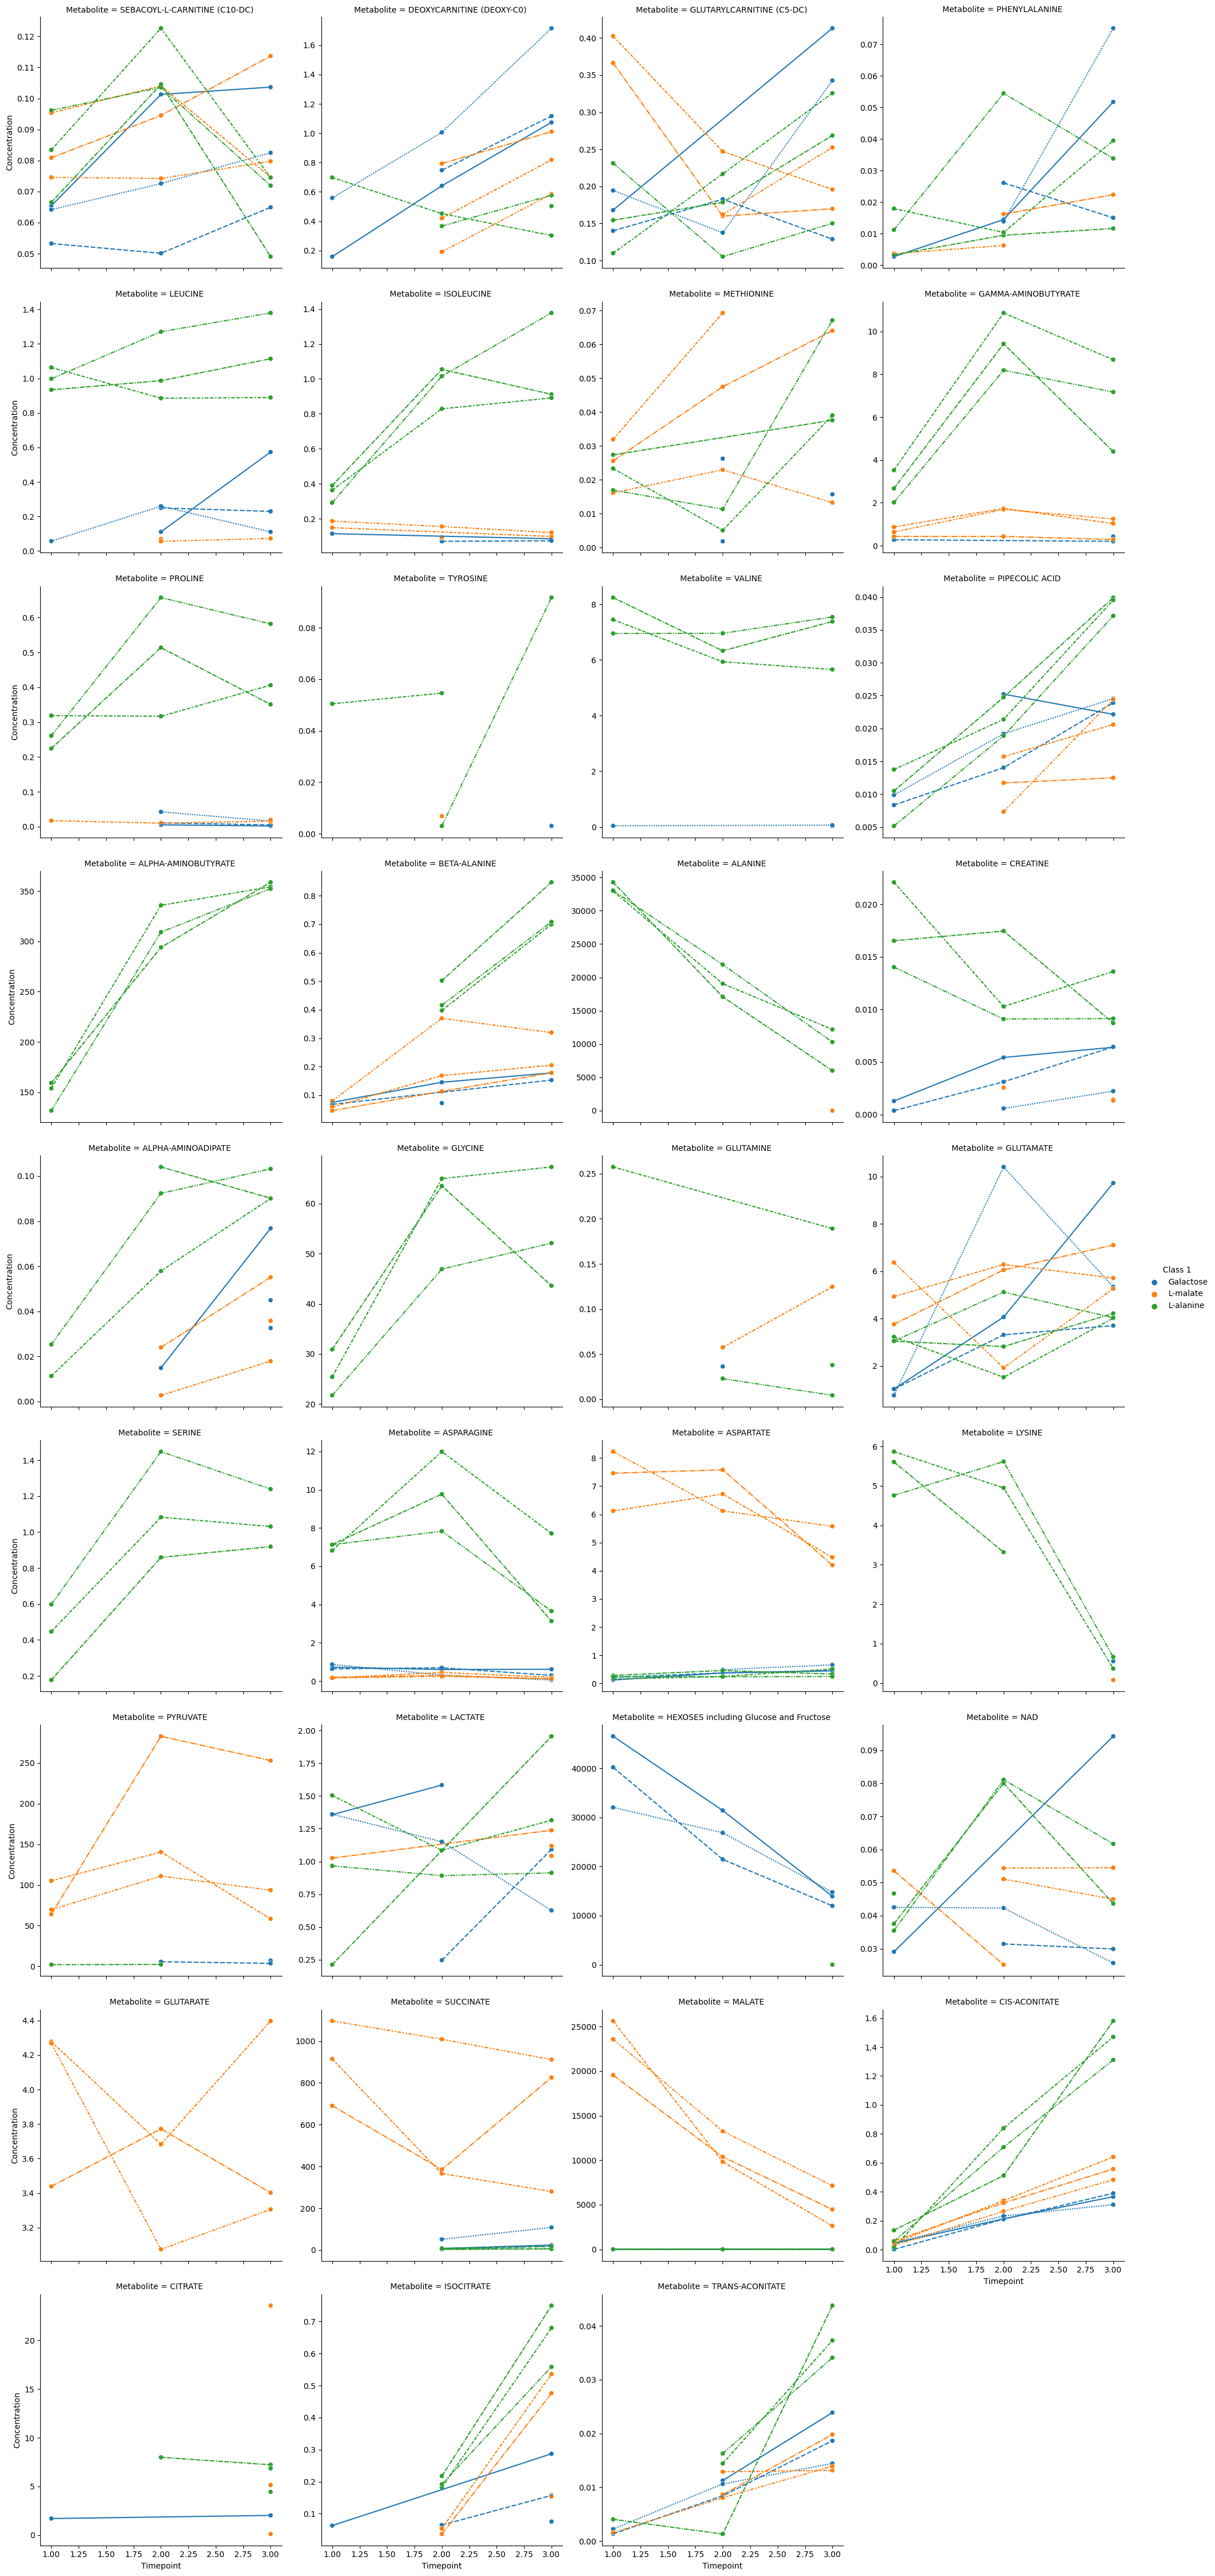

In [82]:
ax = sns.relplot(data = dfl.loc[dfl.Timepoint != 4,:], x = 'Timepoint', y = 'Concentration', hue = 'Class 1', col = 'Metabolite', col_wrap=4, facet_kws={'sharey': False})
ax.map_dataframe(sns.lineplot, 'Timepoint', 'Concentration', hue = 'Class 1', style = 'M')
plt.show()

# Estimate rate per bioreactor

In [84]:
data = []
plot = False
data_rate = []
for m in dfl.M.unique():
    # if not m in ['M5', 'M6', 'M7']:
    #     continue
    for met in dfl.Metabolite.unique():
        # print(met, m)
        idx = (dfl.M == m) & (dfl.Metabolite == met) & (dfl.Timepoint != 4)
        dfi = dfl.loc[idx,['Concentration', 'Hours', 'Carbon source', 'Timepoint']].copy()
        # print(m, met)
        # print(dfi)
        dfi.dropna(axis = 0, inplace=True)
    
        if not len(dfi):
            continue
        cs = dfi['Carbon source'].values[0]  
        # if len(dfi) == 1:
        # Add medium concentrations
        medium_values = control_df.loc[control_df['Class 1']==cs, met].values
        if np.isfinite(medium_values).sum() == 0:
            dfi.loc[-1,:] = [0, 0, cs, 0]
        else:
            dfi.loc[-1,:] = [np.nanmean(medium_values), 0, cs, 0]
        if (2 in dfi.Timepoint.values) and (3 in dfi.Timepoint.values):
            t3_value = dfi.loc[dfi.Timepoint == 3, 'Concentration'].values[0]
            t2_value = dfi.loc[dfi.Timepoint == 2, 'Concentration'].values[0]
            if  t3_value < t2_value:
                # Indicates that the matbolite is being reconsumed, discard last point from estimating rates
                # And compensate by adding time 0
                dfi = dfi.loc[dfi.Timepoint != 3, :]
                # dfi.loc[-1,:] = [medium_dict[cs][met], 0, cs, 0]
        
            # The maximum value 
        # print(dfi)
        time_conc_dict = {key: (value['Hours'], value['Concentration']) for key, value in dfi[['Hours', 'Concentration']].to_dict(orient = 'index').items()}
        max_time = max(list(time_conc_dict.keys()))
        rel = M_to_rel[m]
        OD = od_df[['Hours', rel]].copy()
        OD.dropna(inplace=True)
        m_data = []
        for index, val_tuple in time_conc_dict.items():
            time, conc = val_tuple
            # Calculate cumulative OD
            tidx = OD.Hours < time+0.5

            cum_OD = scipy.integrate.simpson(OD.loc[tidx, rel], OD.loc[tidx, 'Hours'])
            data.append([m, met, time, conc, cum_OD, cs])
            m_data.append([conc, cum_OD])

        m_df = pd.DataFrame(m_data, columns = ['Concentration', 'Cumulative OD'])
        popt, pcov = scipy.optimize.curve_fit(lambda x,a,b: a*x+b, m_df['Cumulative OD'], m_df['Concentration'])
        rate = popt[0]
        data_rate.append([m, met, cs, rate, pcov[0,0]])
        if plot:
            print(m, met)
            plt.scatter(m_df['Cumulative OD'], m_df['Concentration'])
            x = np.linspace(0,max_time, 4)
            plt.plot(x, rate*x + popt[1])
            plt.show()
df_conc_biomass = pd.DataFrame(data, columns = ['M', 'Metabolite', 'Time', 'Concentration', 'Cumulative OD', 'Carbon source'])
df_rate = pd.DataFrame(data_rate, columns = ['M', 'Metabolite', 'Carbon source', 'Rate', 'Rate var'])

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_p

Galactose SEBACOYL-L-CARNITINE (C10-DC) 


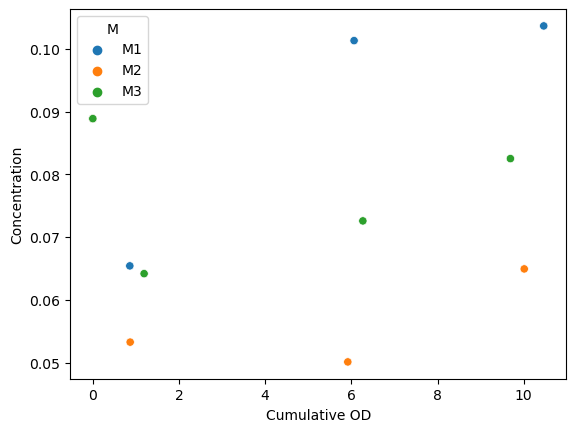

Galactose DEOXYCARNITINE (DEOXY-C0) 


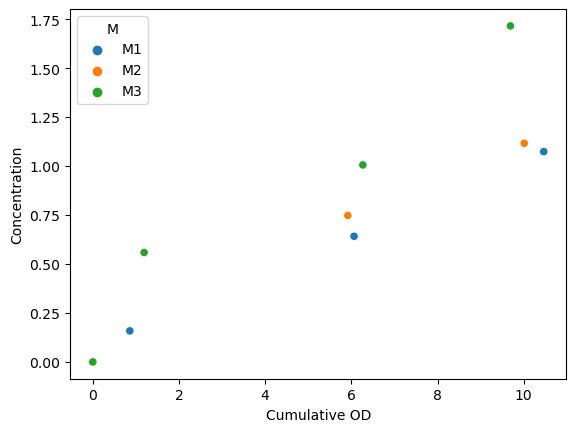

Galactose GLUTARYLCARNITINE (C5-DC) 


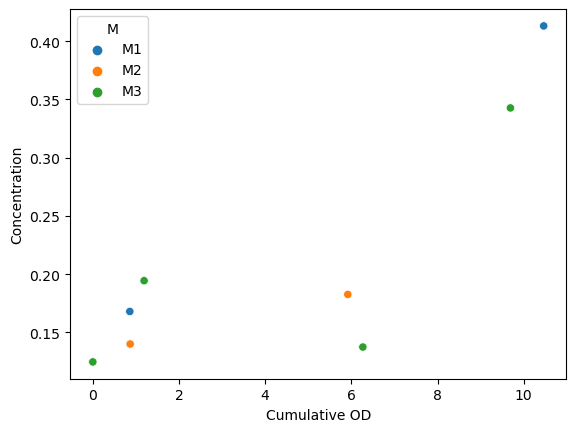

Galactose PHENYLALANINE 


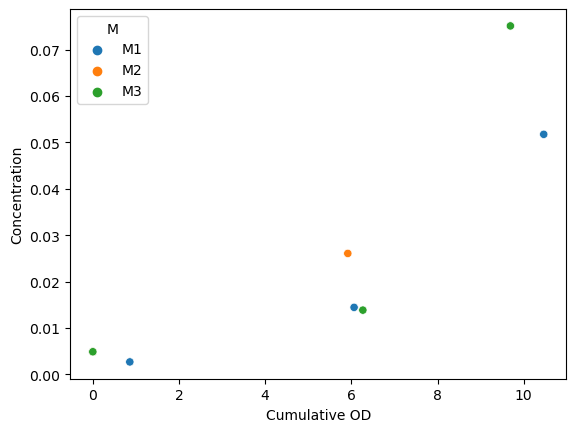

Galactose LEUCINE 


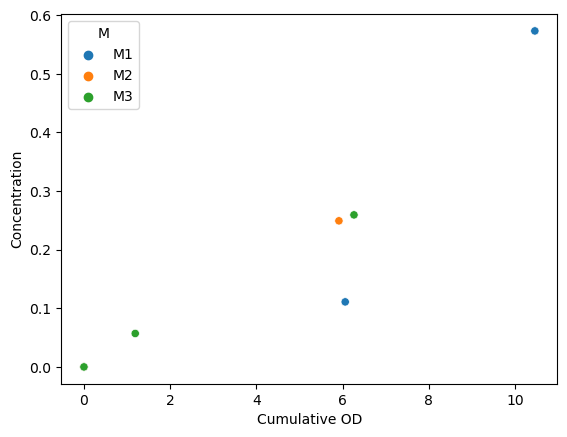

Galactose ISOLEUCINE 


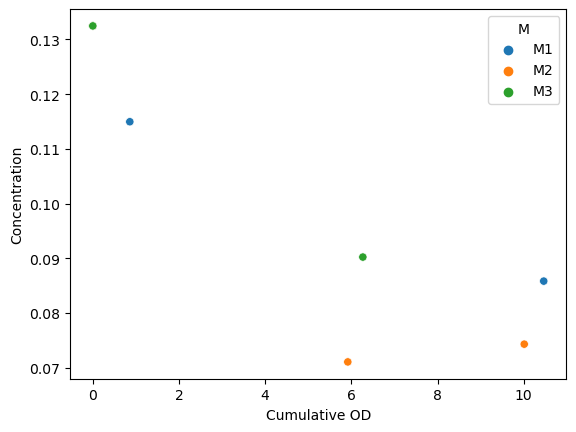

Galactose METHIONINE 


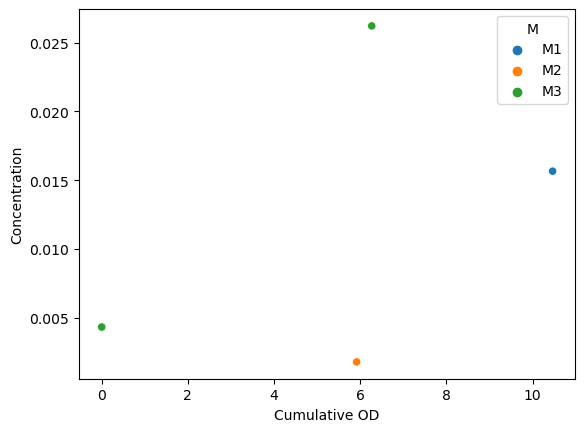

Galactose GAMMA-AMINOBUTYRATE 


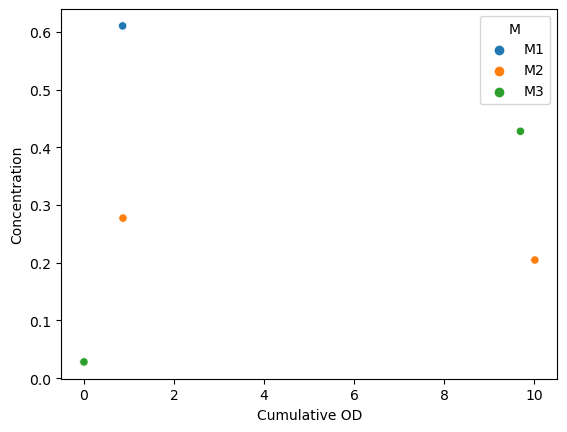

Galactose PROLINE 


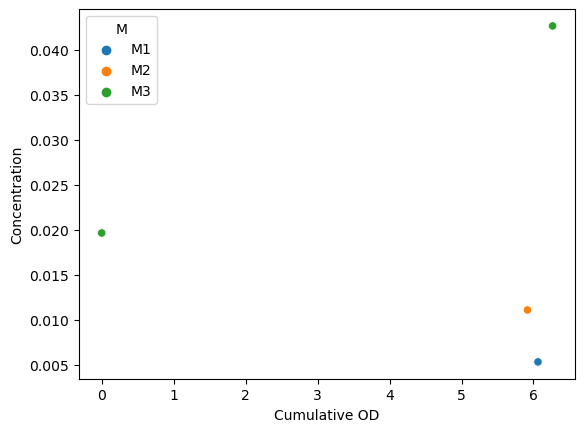

Galactose VALINE 


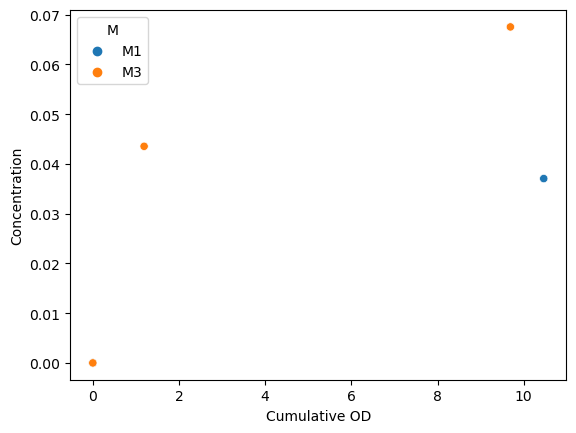

Galactose PIPECOLIC ACID 


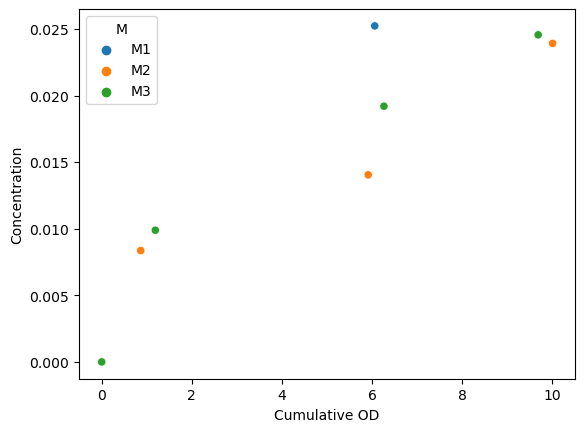

Galactose BETA-ALANINE 


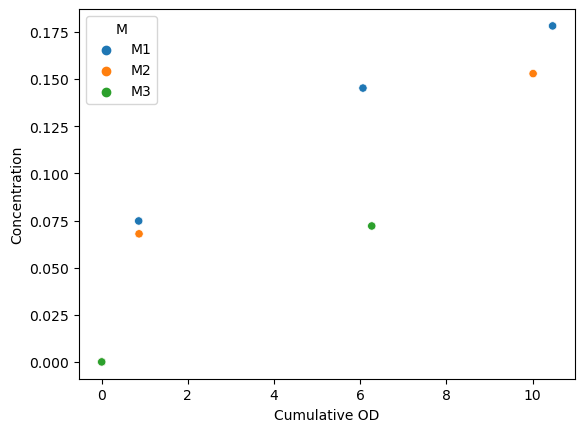

Galactose ALANINE 


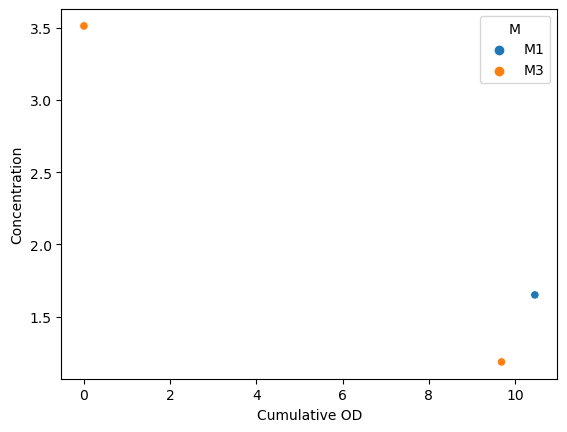

Galactose CREATINE 


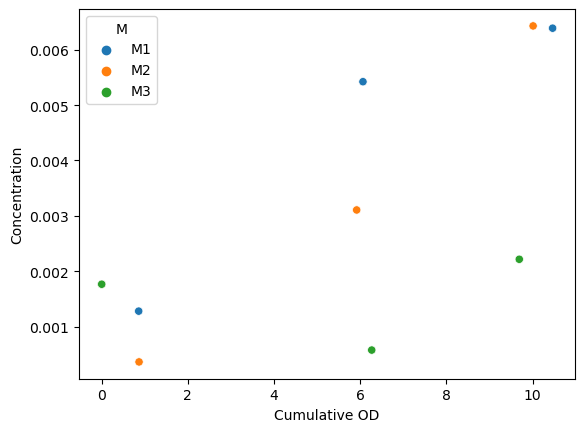

Galactose ALPHA-AMINOADIPATE 


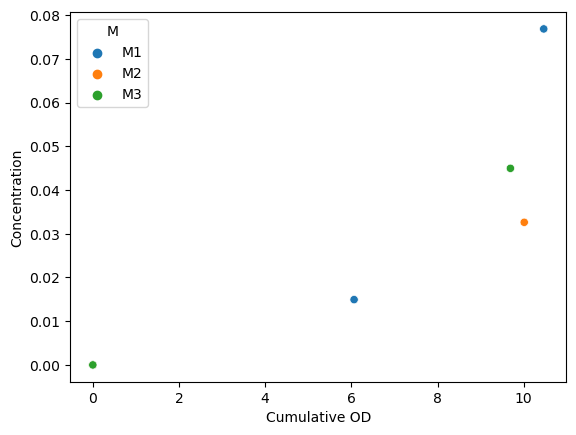

Galactose GLUTAMATE 


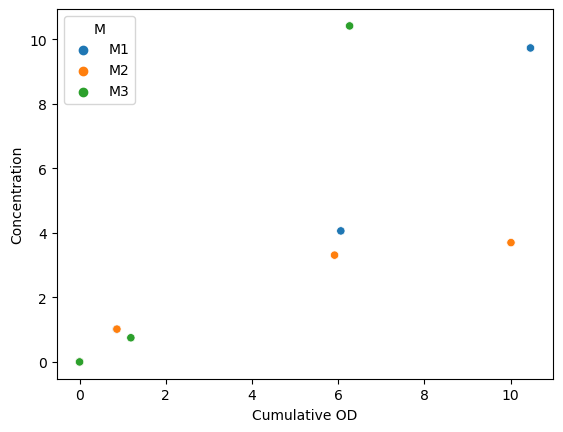

Galactose ASPARAGINE 


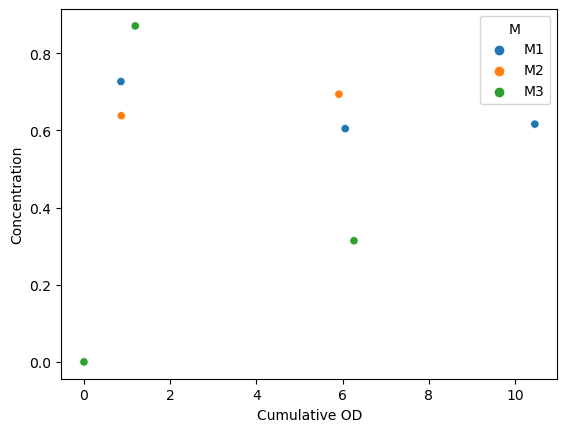

Galactose ASPARTATE 


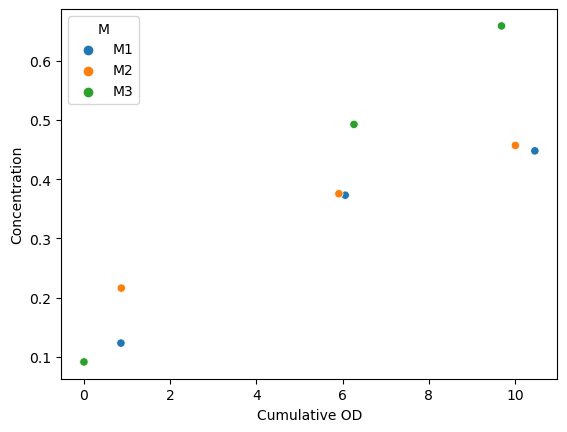

Galactose PYRUVATE 


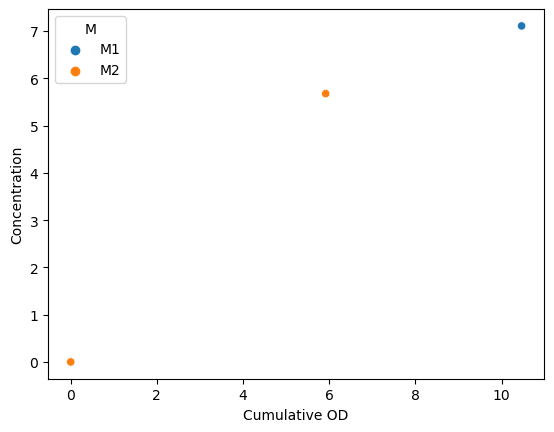

Galactose LACTATE 


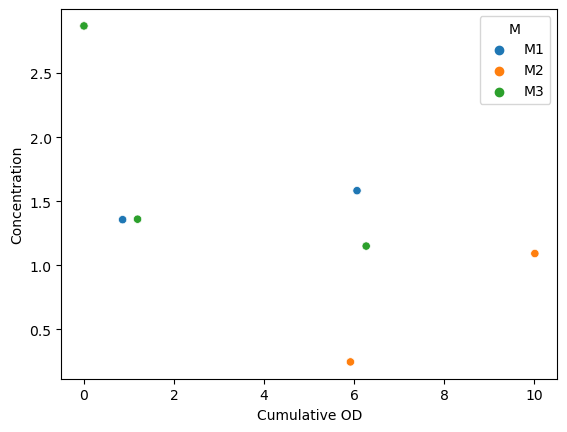

Galactose HEXOSES including Glucose and Fructose 


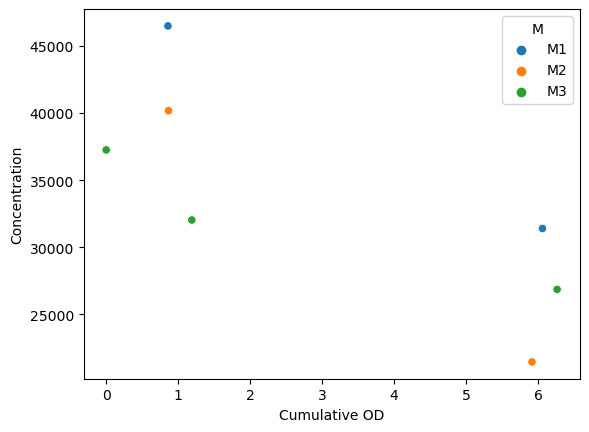

Galactose NAD 


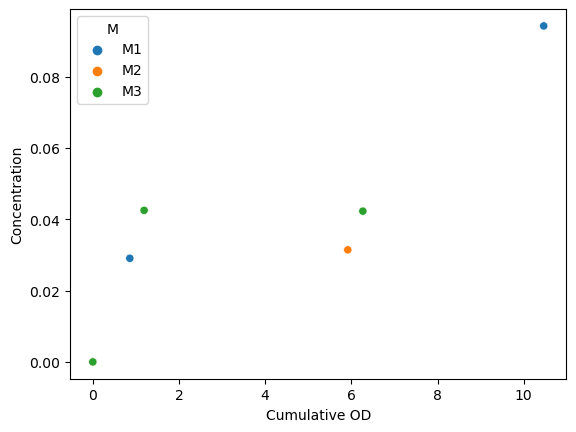

Galactose SUCCINATE 


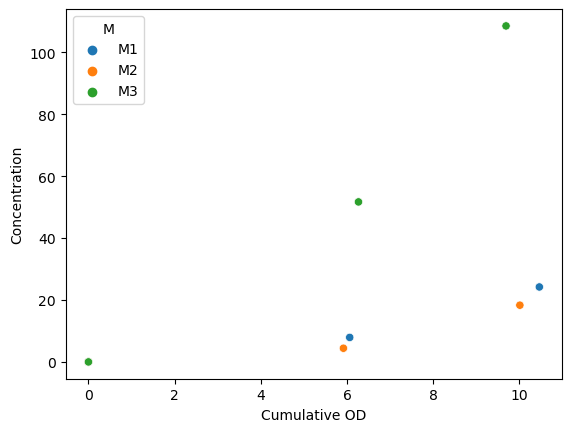

Galactose MALATE 


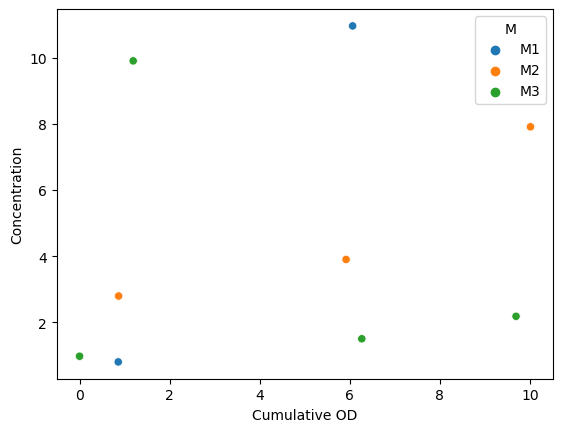

Galactose CIS-ACONITATE 


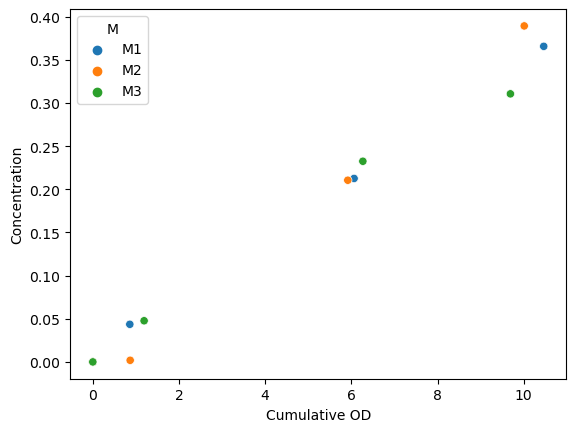

Galactose ISOCITRATE 


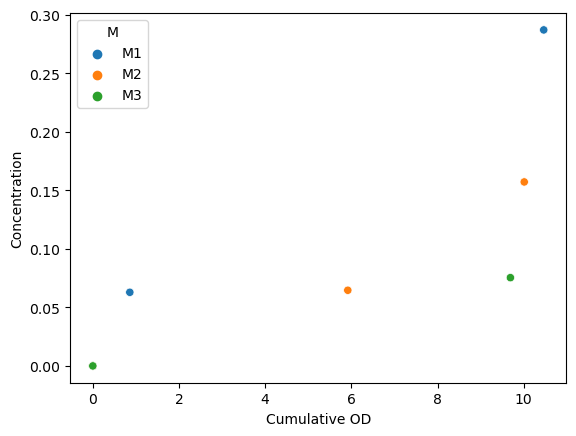

Galactose TRANS-ACONITATE 


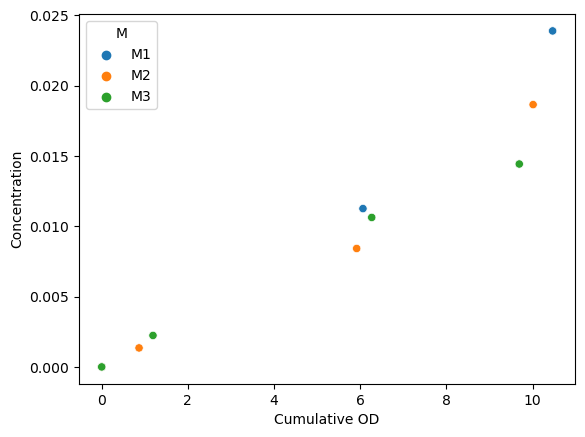

L-malate SEBACOYL-L-CARNITINE (C10-DC) 


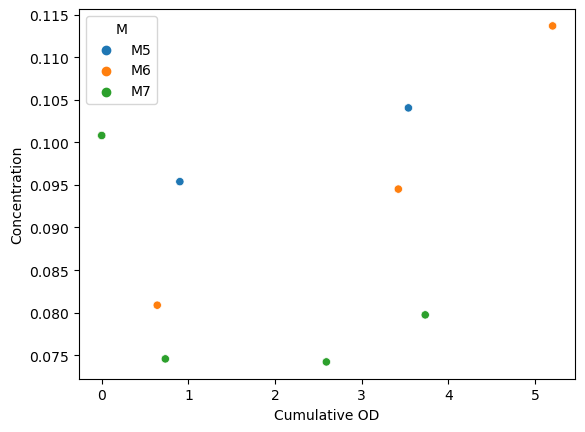

L-malate DEOXYCARNITINE (DEOXY-C0) 


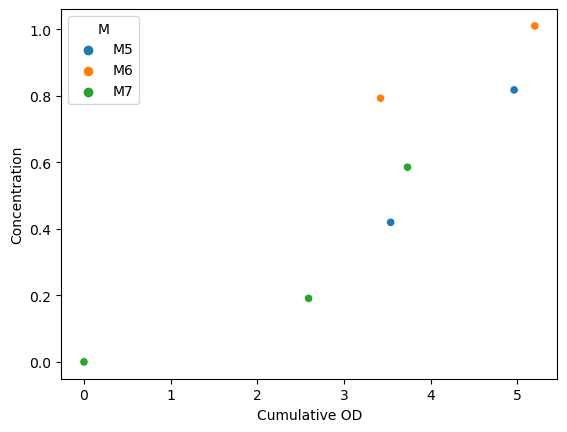

L-malate GLUTARYLCARNITINE (C5-DC) 


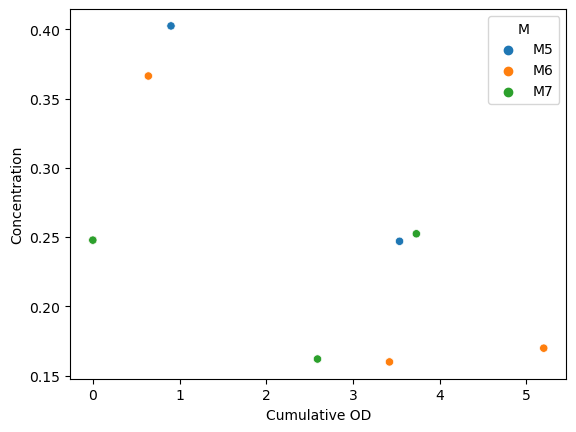

L-malate PHENYLALANINE 


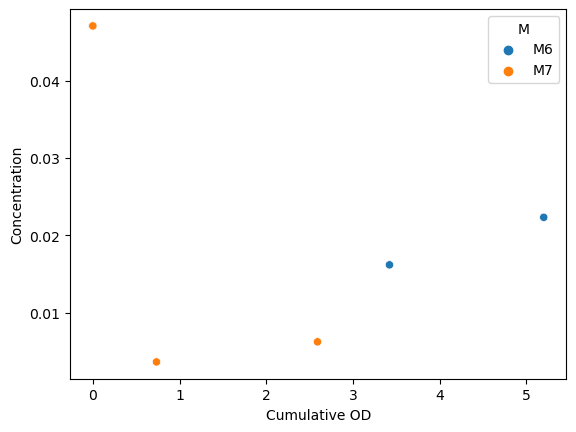

L-malate LEUCINE 


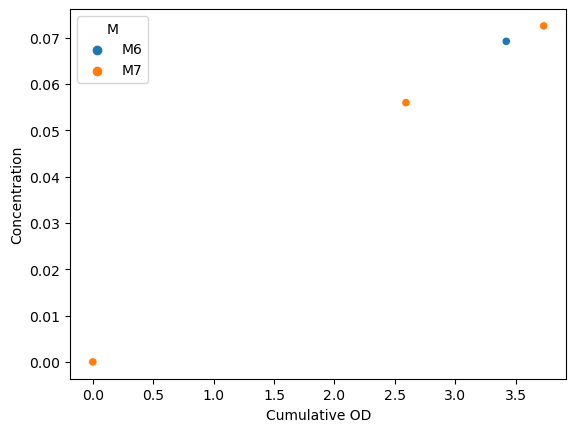

L-malate ISOLEUCINE 


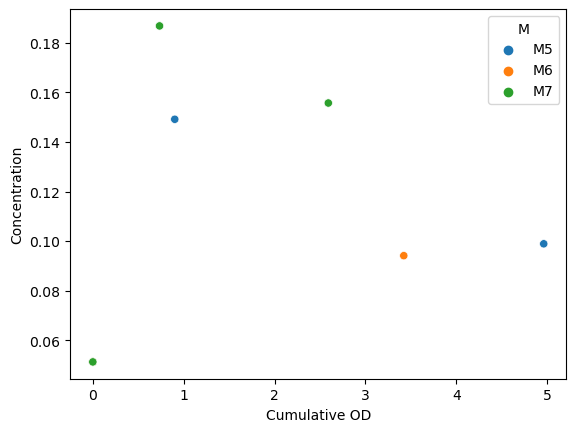

L-malate METHIONINE 


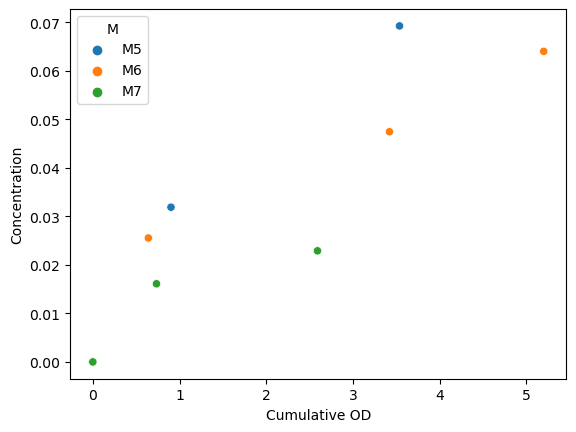

L-malate GAMMA-AMINOBUTYRATE 


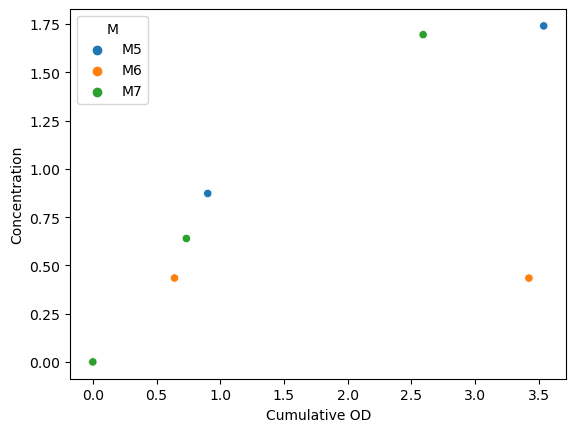

L-malate PROLINE 


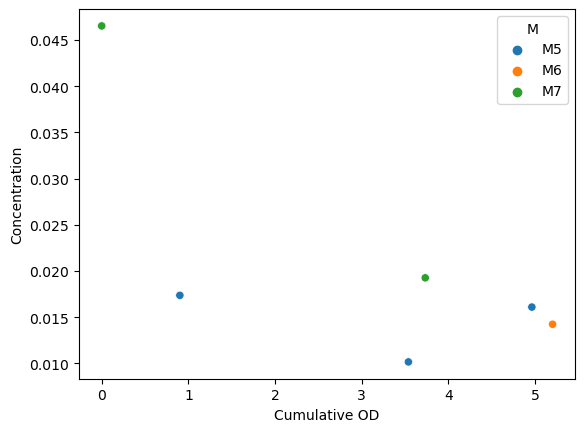

L-malate PIPECOLIC ACID 


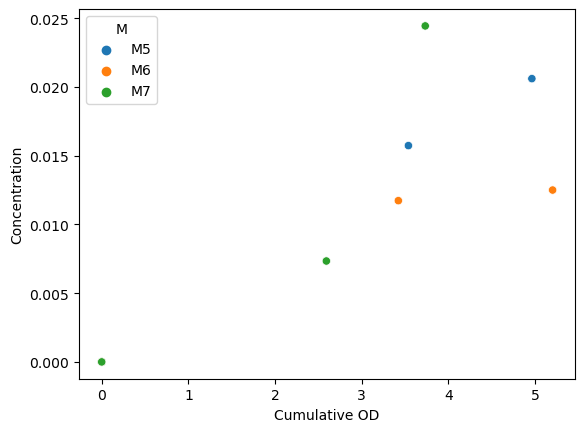

L-malate BETA-ALANINE 


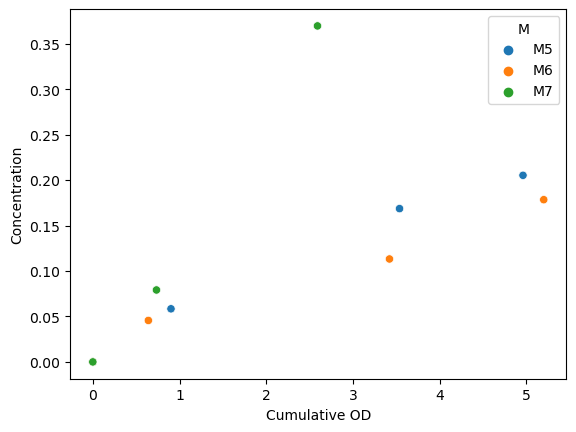

L-malate CREATINE 


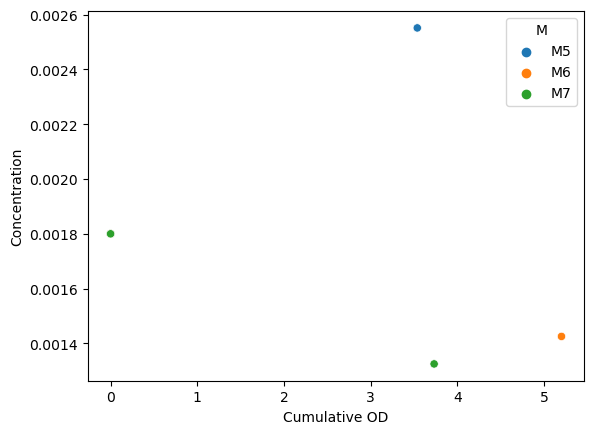

L-malate ALPHA-AMINOADIPATE 


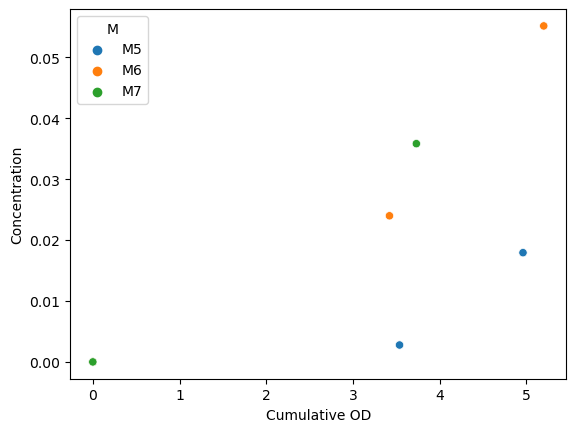

L-malate GLUTAMATE 


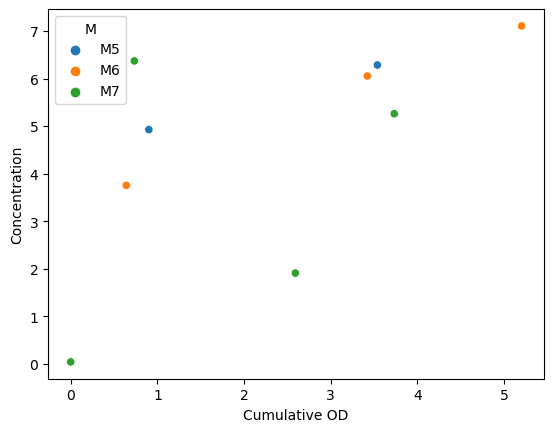

L-malate ASPARAGINE 


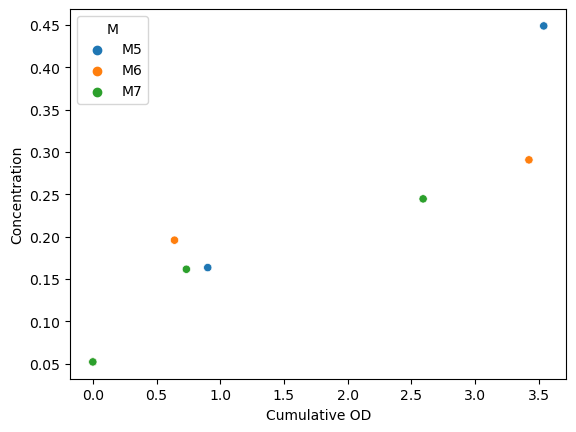

L-malate ASPARTATE 


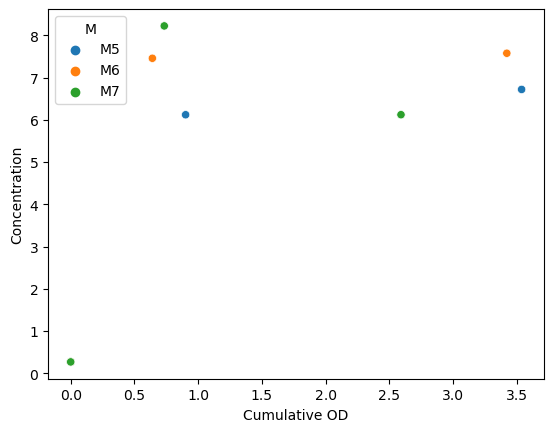

L-malate PYRUVATE 


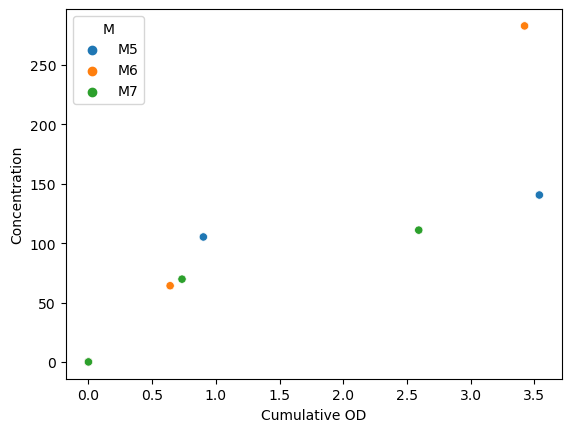

L-malate LACTATE 


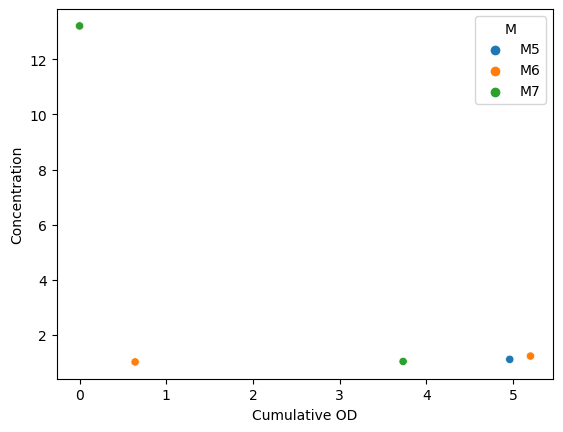

L-malate NAD 


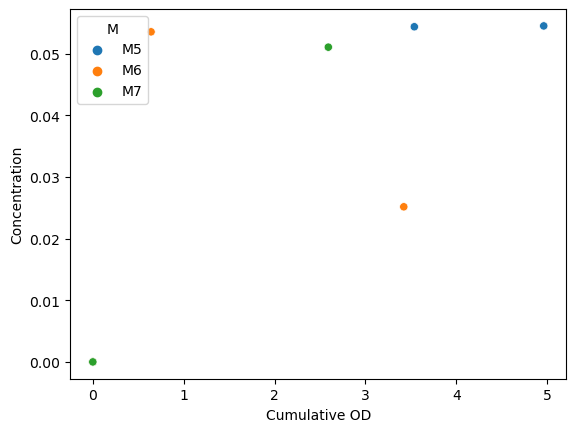

L-malate SUCCINATE 


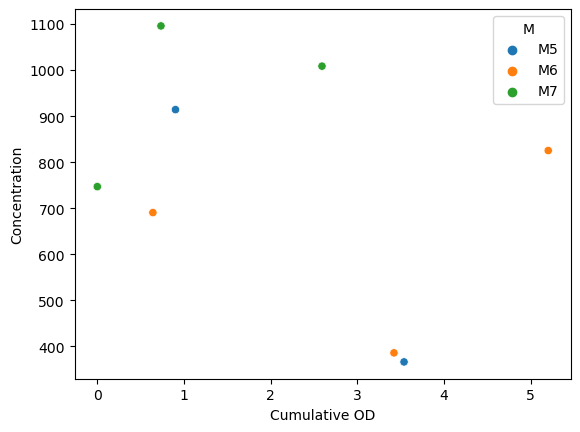

L-malate MALATE 


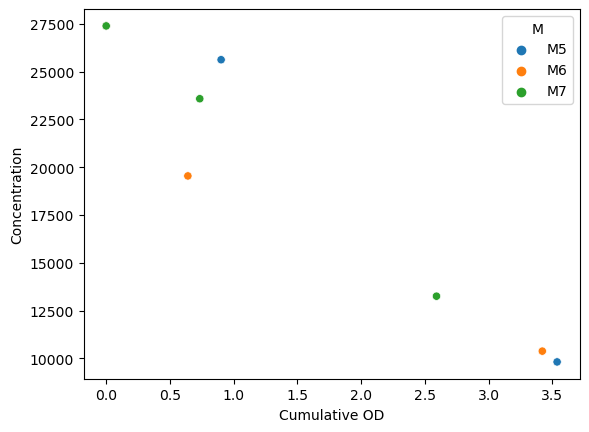

L-malate CIS-ACONITATE 


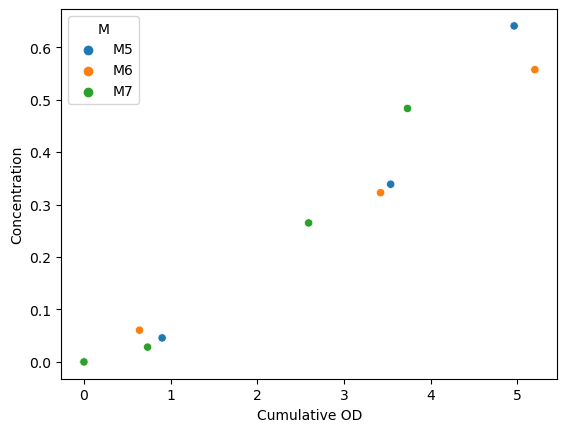

L-malate CITRATE 


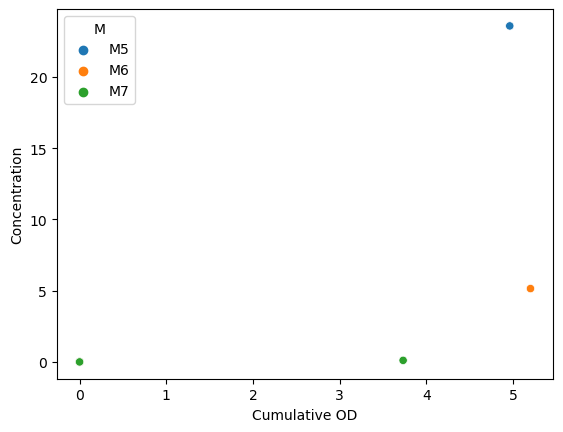

L-malate ISOCITRATE 


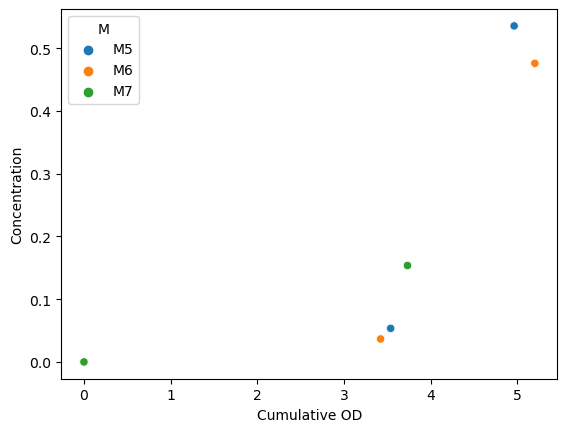

L-malate TRANS-ACONITATE 


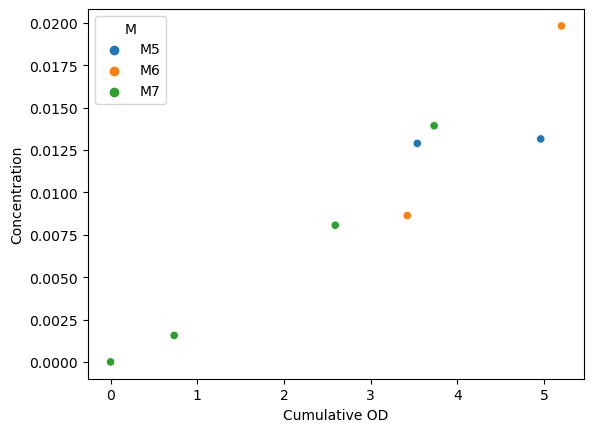

L-malate GLUTARATE 


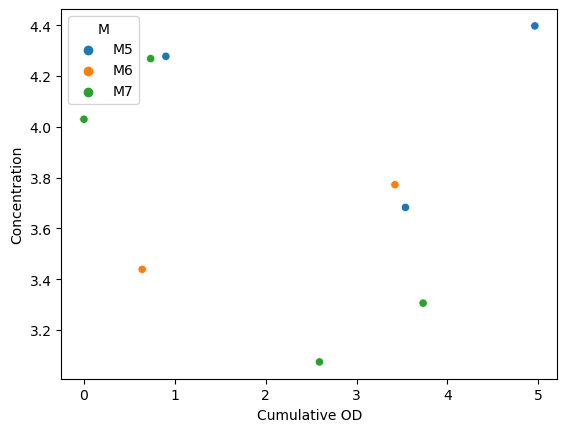

L-alanine SEBACOYL-L-CARNITINE (C10-DC) 


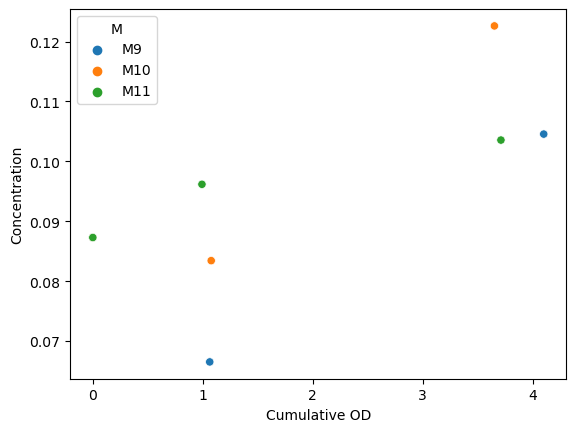

L-alanine DEOXYCARNITINE (DEOXY-C0) 


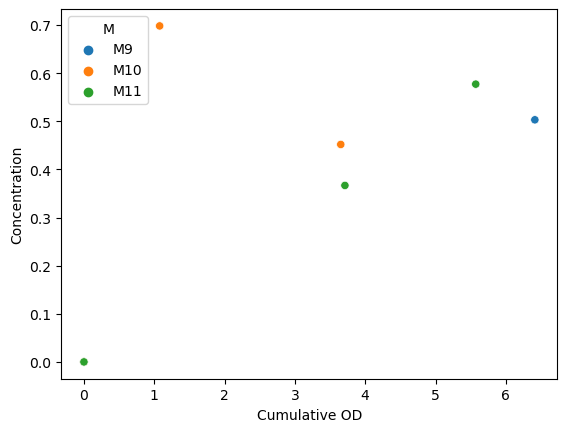

L-alanine GLUTARYLCARNITINE (C5-DC) 


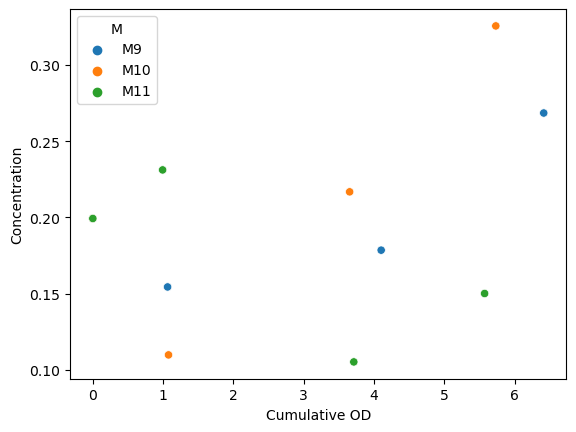

L-alanine PHENYLALANINE 


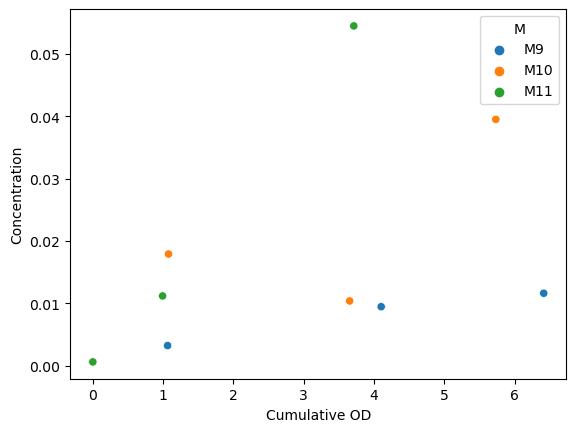

L-alanine LEUCINE 


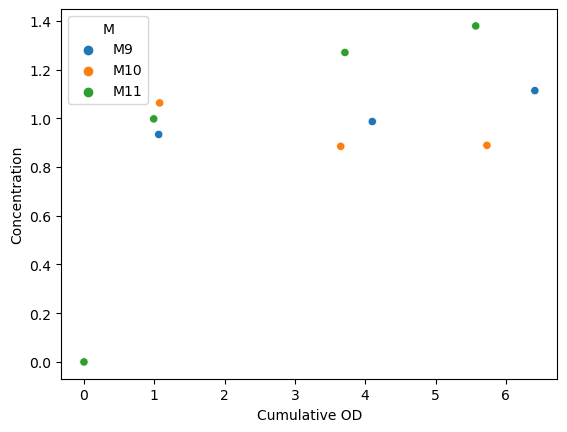

L-alanine ISOLEUCINE 


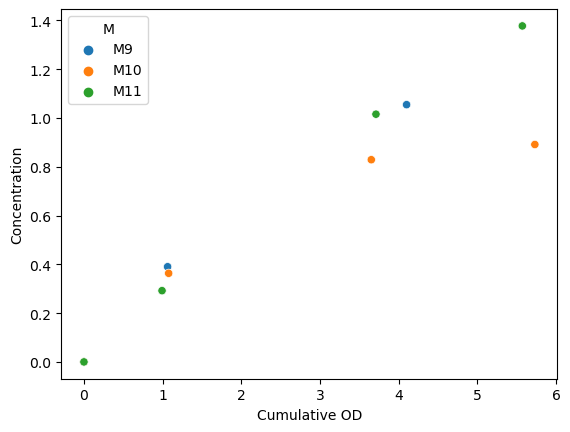

L-alanine METHIONINE 


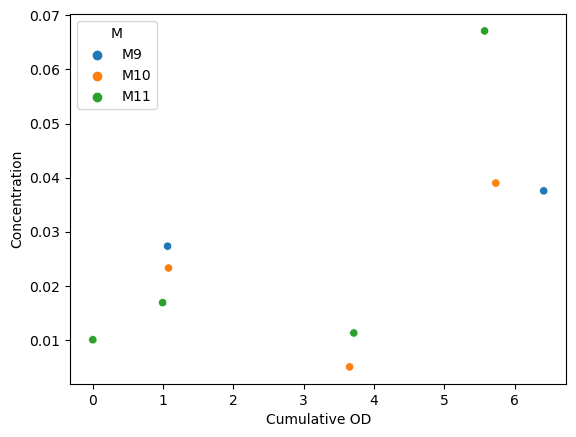

L-alanine GAMMA-AMINOBUTYRATE 


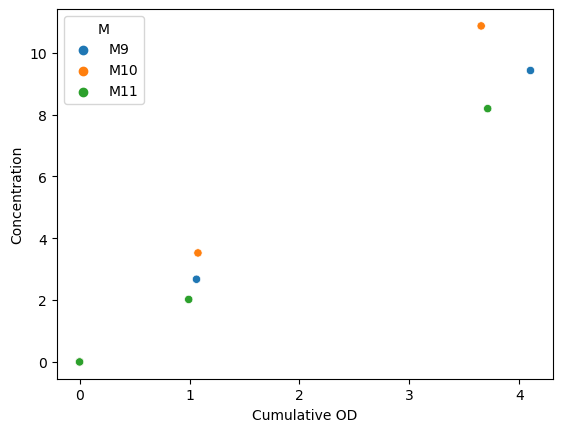

L-alanine PROLINE 


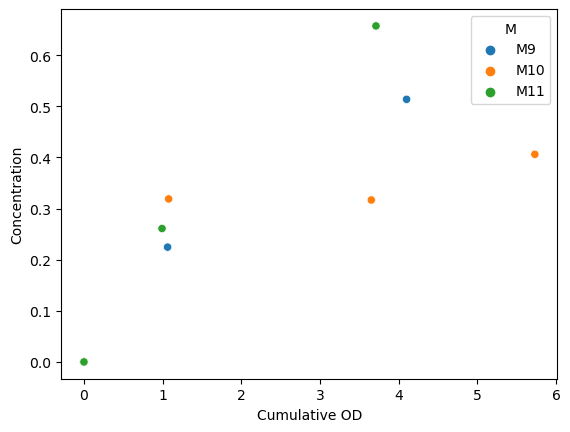

L-alanine VALINE 


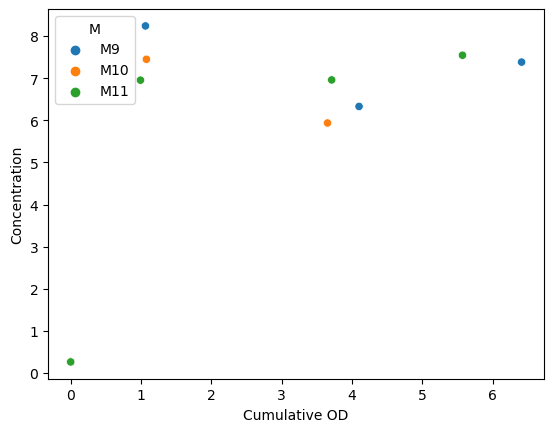

L-alanine PIPECOLIC ACID 


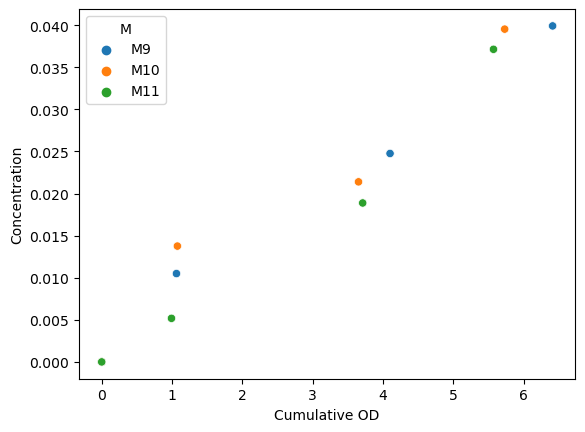

L-alanine BETA-ALANINE 


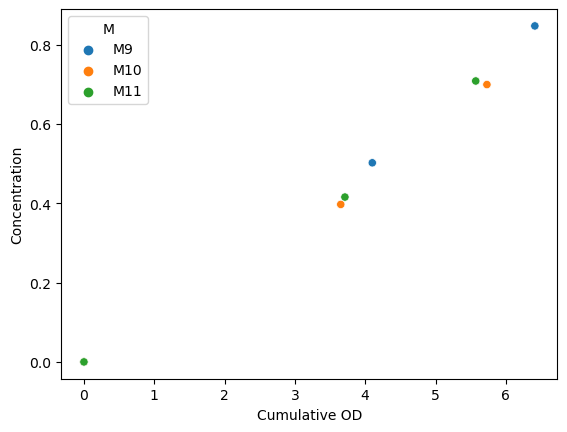

L-alanine ALANINE 


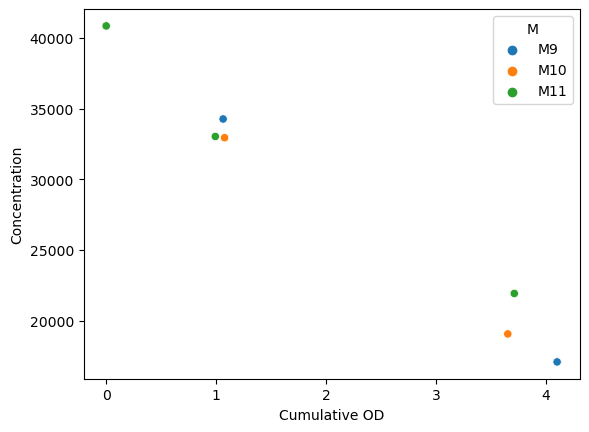

L-alanine CREATINE 


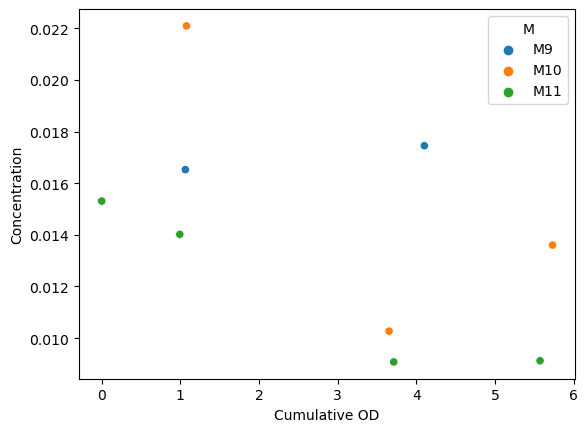

L-alanine ALPHA-AMINOADIPATE 


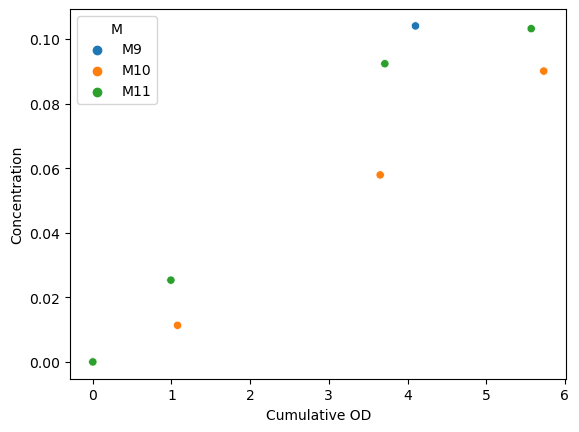

L-alanine GLUTAMATE 


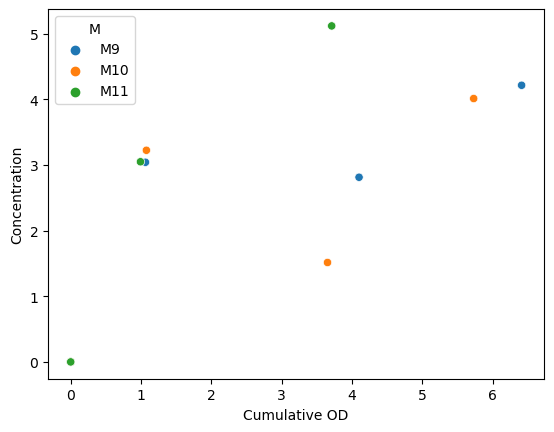

L-alanine ASPARAGINE 


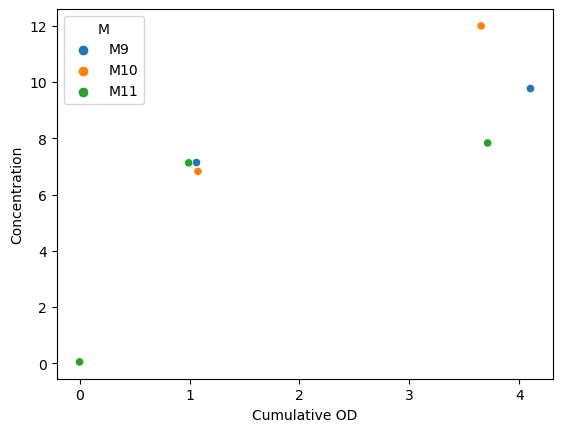

L-alanine ASPARTATE 


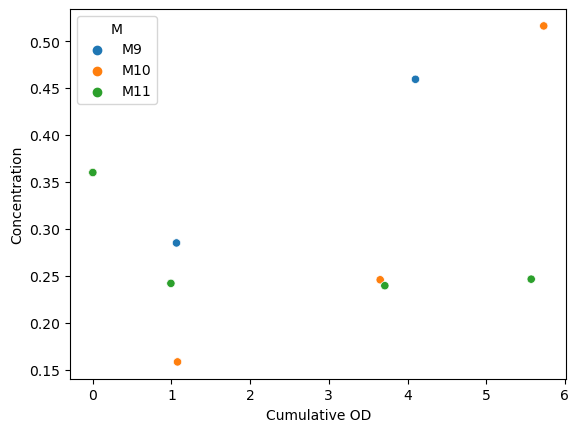

L-alanine LACTATE 


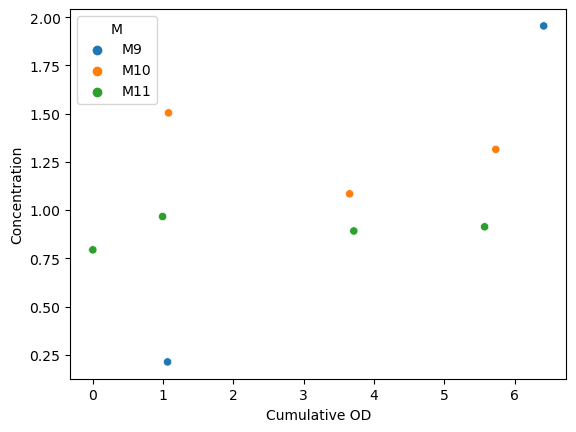

L-alanine NAD 


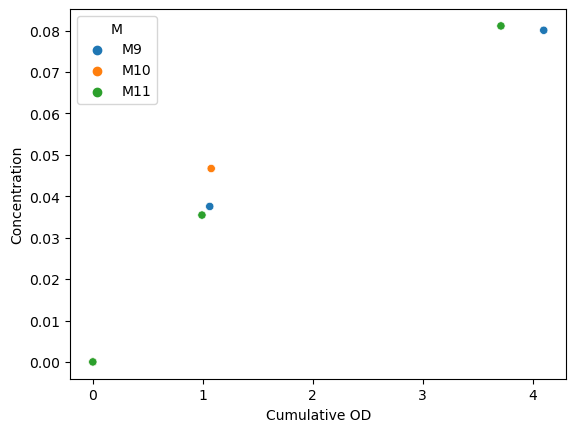

L-alanine SUCCINATE 


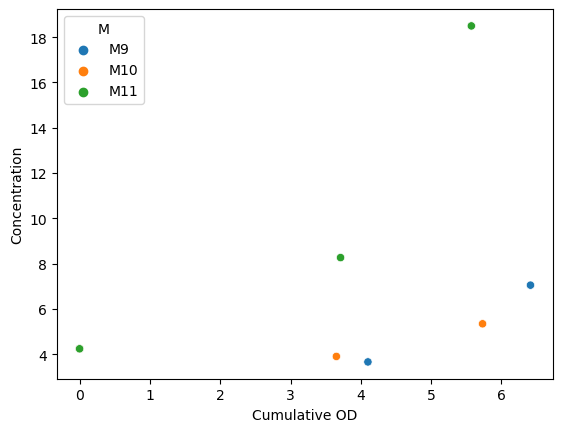

L-alanine MALATE 


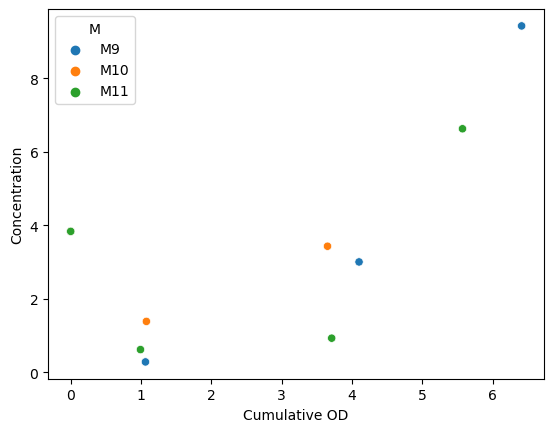

L-alanine CIS-ACONITATE 


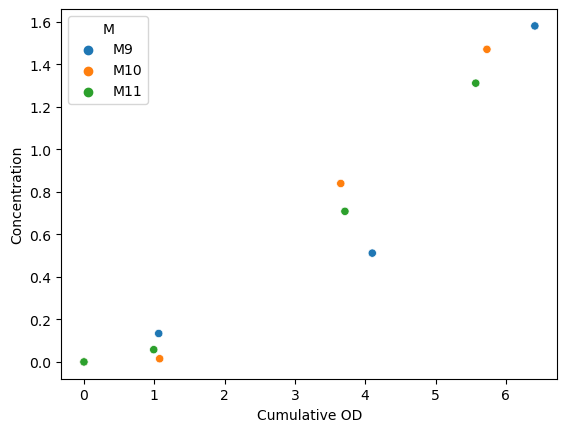

L-alanine CITRATE 


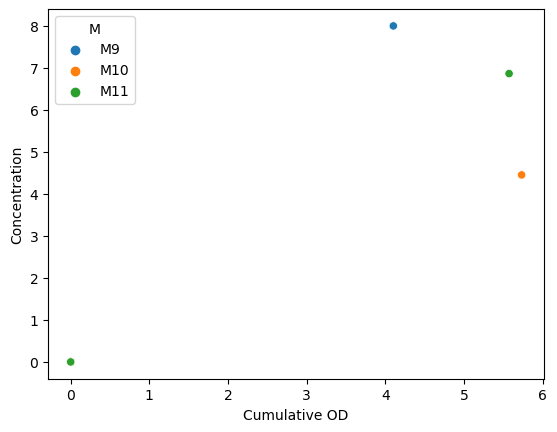

L-alanine ISOCITRATE 


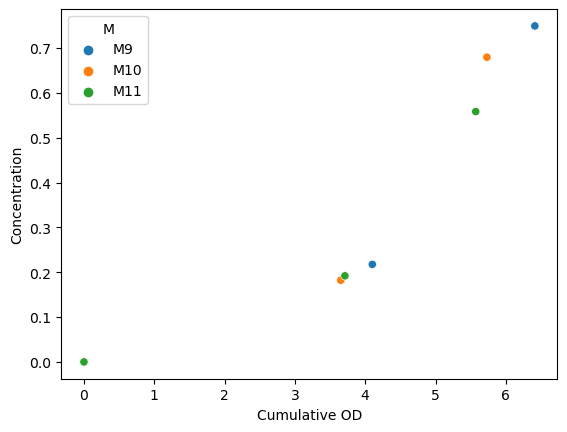

L-alanine TRANS-ACONITATE 


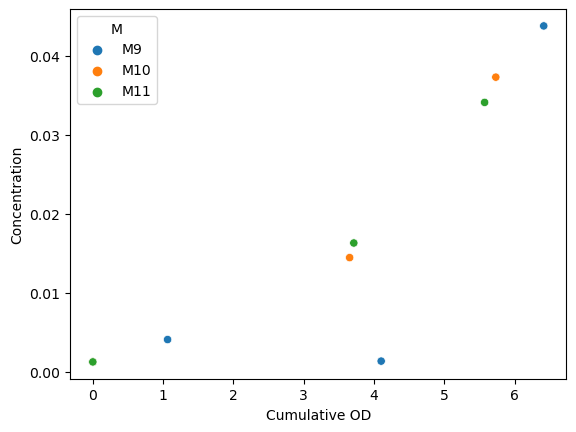

L-alanine TYROSINE 


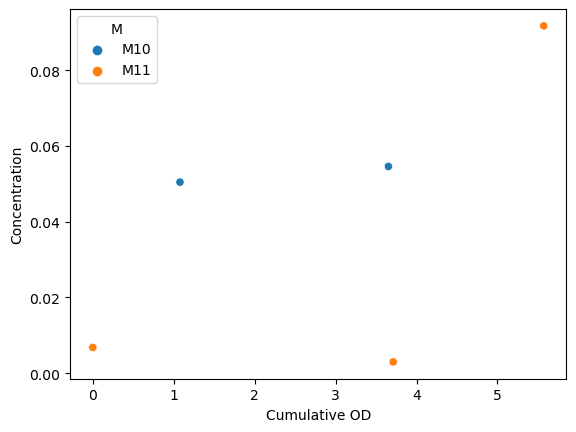

L-alanine GLUTAMINE 


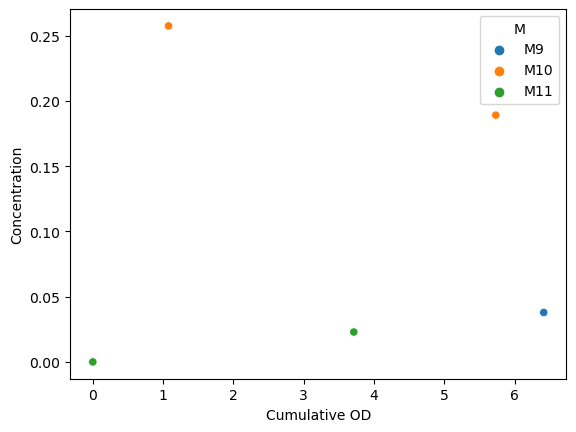

L-alanine LYSINE 


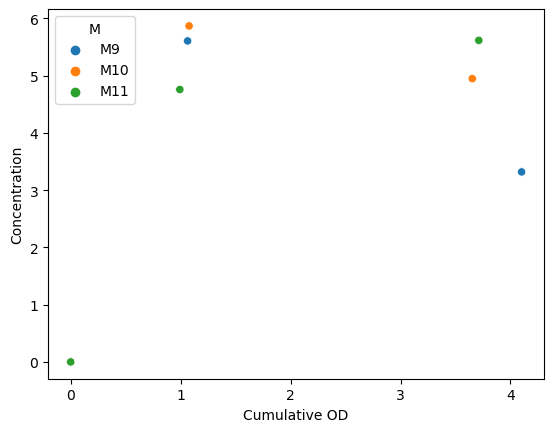

L-alanine ALPHA-AMINOBUTYRATE 


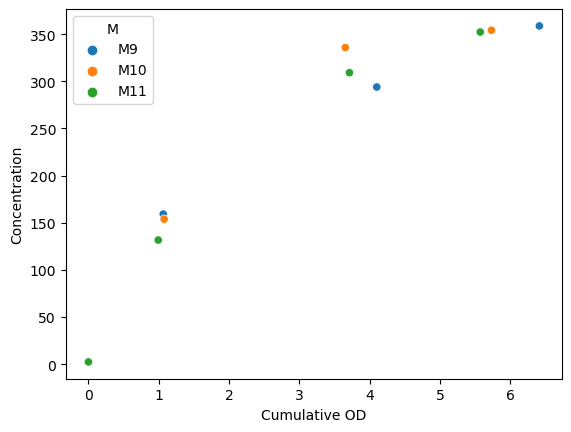

L-alanine GLYCINE 


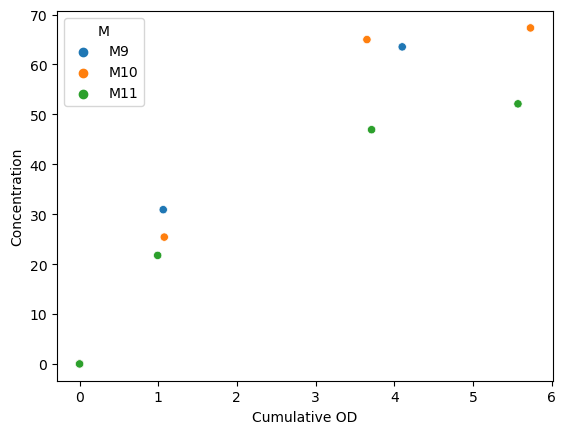

L-alanine SERINE 


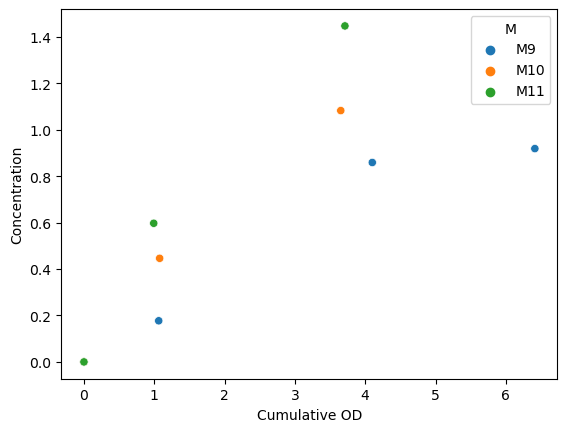

In [85]:
average_rate_data = []
for cs in df_conc_biomass['Carbon source'].unique():
    for m in df_conc_biomass.Metabolite.unique():
        idx = (df_conc_biomass['Carbon source'] == cs) & (df_conc_biomass.Metabolite==m)
        if len( df_conc_biomass.loc[idx, 'Concentration']) > 3:
            print(cs, m)
            sns.scatterplot(data = df_conc_biomass.loc[idx,:], x = 'Cumulative OD', y = 'Concentration', hue = 'M')
            plt.show()
            popt, pcov = scipy.optimize.curve_fit(lambda x,a,b: (a*x)+b, df_conc_biomass.loc[idx, 'Cumulative OD'], df_conc_biomass.loc[idx, 'Concentration'])
            perr = np.sqrt(np.diag(pcov))
            average_rate_data.append([cs, m, popt[0], perr[0]])
average_rate_df = pd.DataFrame(average_rate_data, columns = ['Carbon source', 'Metabolite', 'Rate', 'Rate std'])

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


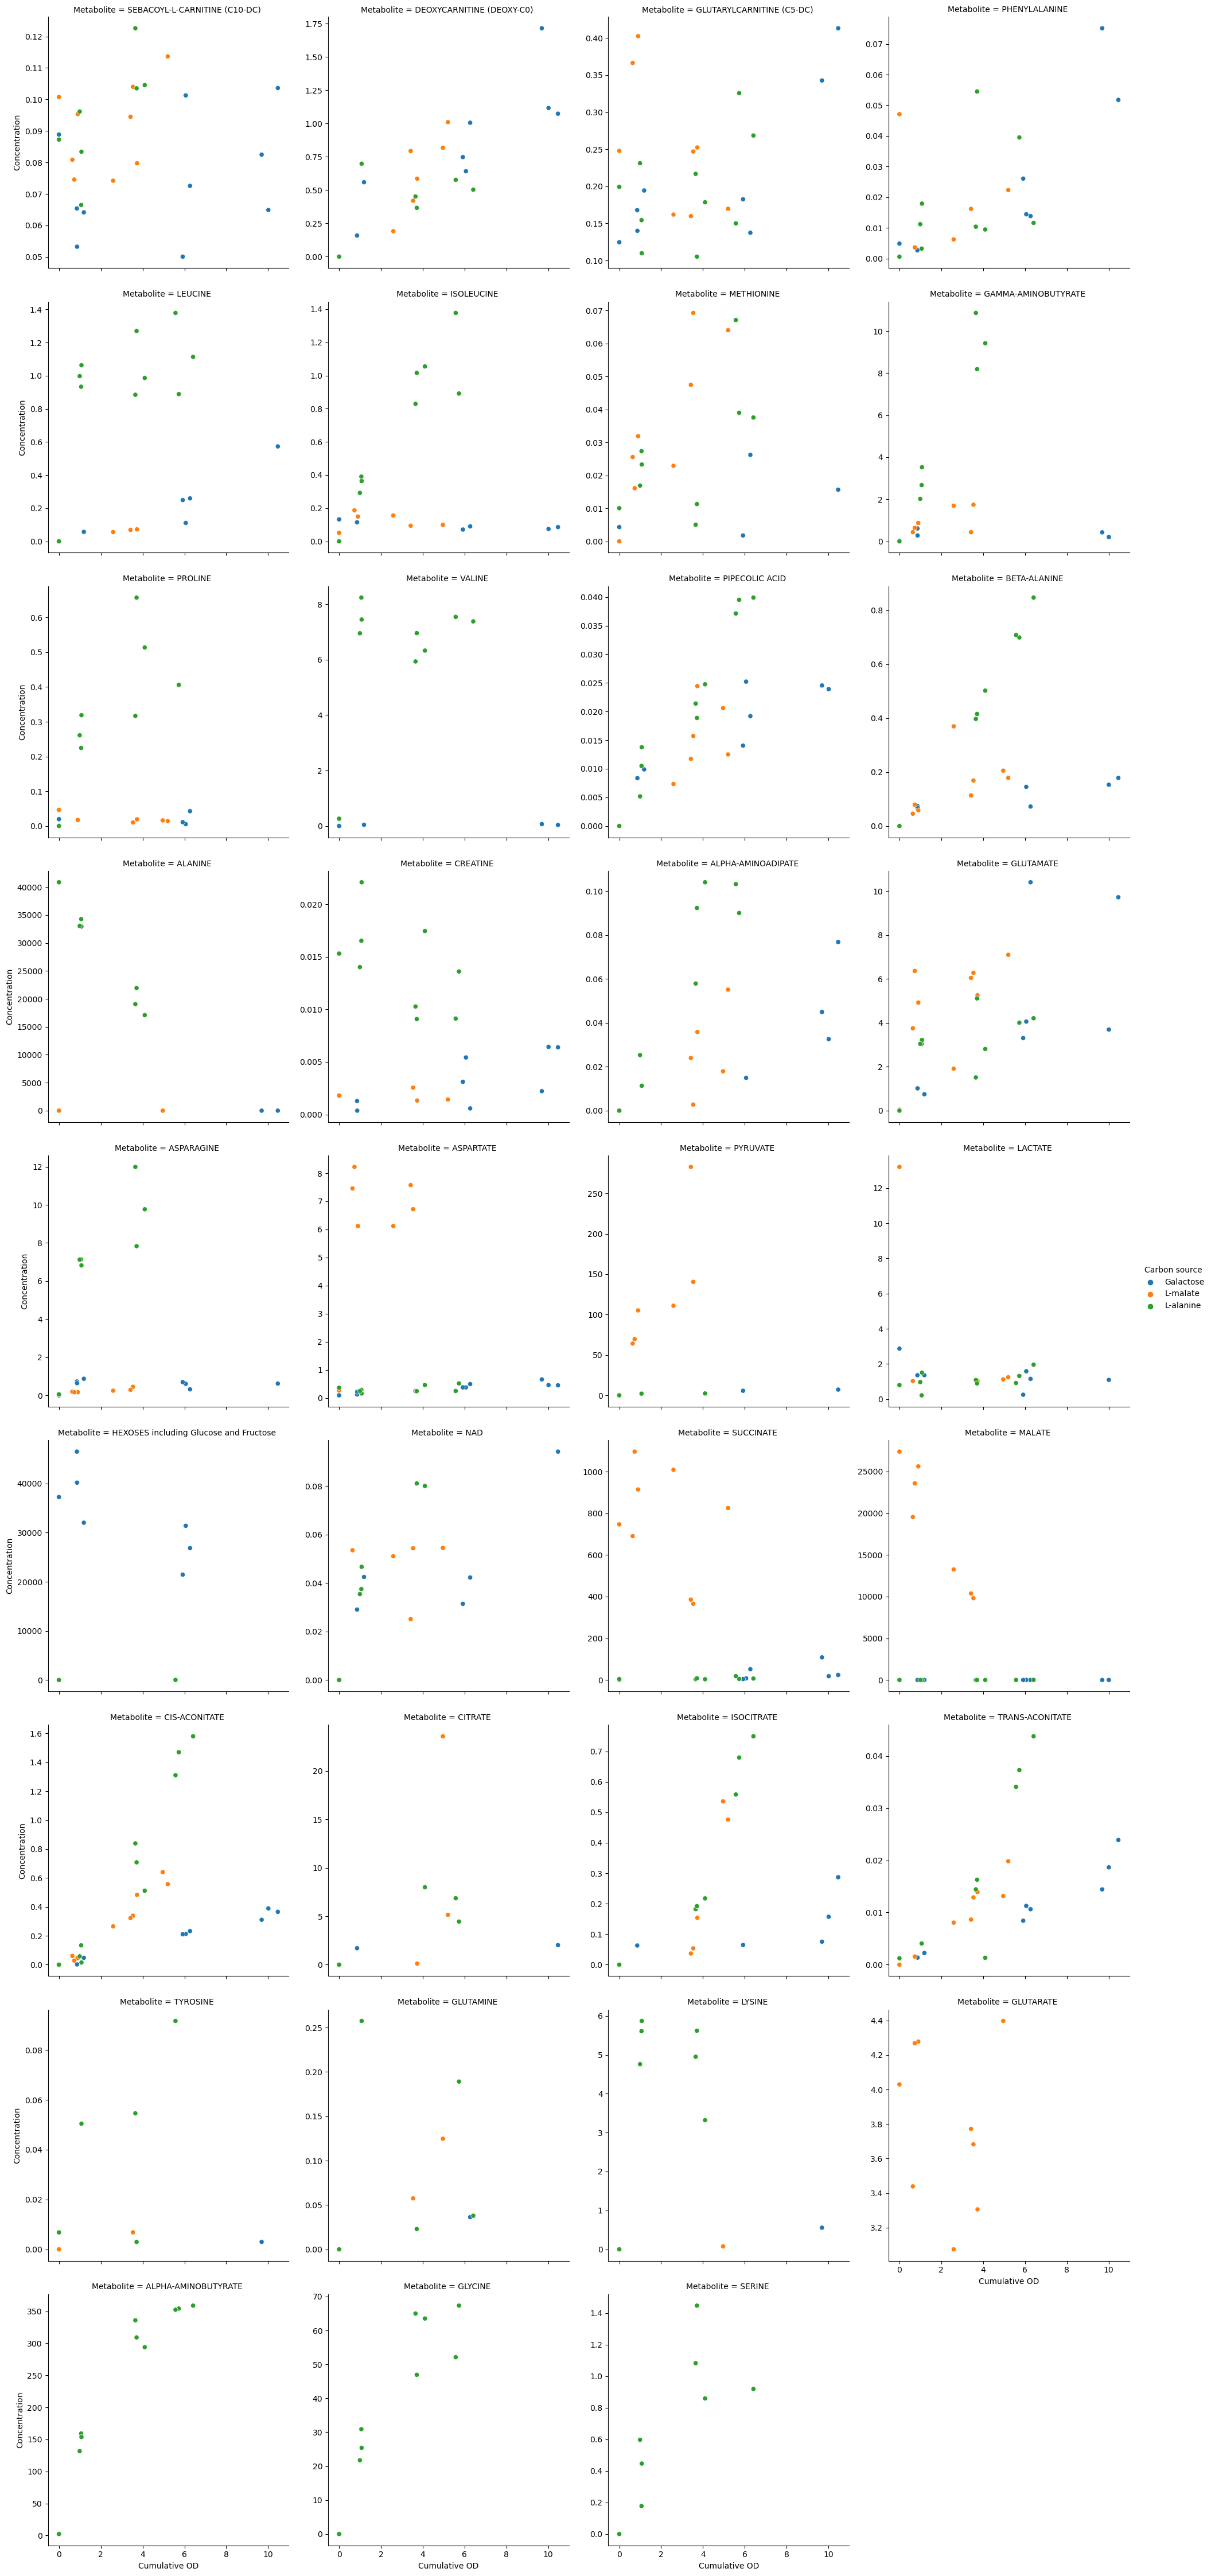

In [86]:
sns.relplot(data = df_conc_biomass, x = 'Cumulative OD', y = 'Concentration', col = 'Metabolite', col_wrap=4, facet_kws={'sharey': False}, hue = 'Carbon source')
plt.show()

In [88]:
model_ez = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')
model_ez.id = 'moment-iJO1366'
model_ez.solver = 'gurobi'
model_ez.reactions.EX_glc__D_e.lower_bound = 0


Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19


In [89]:
cs_to_exchange = {
    'Galactose': 'EX_gal_e',
    'L-malate': 'EX_mal__L_e',
    'L-alanine': 'EX_ala__L_e'
}

In [90]:
measured_metabolite_ids = [f'{m_id}_c' for m_id in mapping_dict.values() if isinstance(m_id, str)]

In [91]:
uptake_rate = 5
sp_dict = {}
for cs, ex_id in cs_to_exchange.items():
    with model_ez as model:
        r_ex = model.reactions.get_by_id(ex_id)
        r_ex.lower_bound = - uptake_rate
        sp_dict[cs] = leakage.estimate_shadow_prices(model, delta = 0.01, metabolites=measured_metabolite_ids)
        

In [92]:
mv_df = pd.DataFrame(sp_dict)*-1

In [93]:
sp_dict[cs]

{'acon_C_c': -0.07484620183104695,
 'cit_c': -0.07480867247233736,
 'fru_c': -0.11433872352386576,
 'icit_c': -0.07481027617400882,
 'lac__L_c': -0.051336987658751054,
 'glu__L_c': -0.07374797003268374,
 'mal__L_c': -0.05090038288323162,
 'nad_c': -0.3956236169833316,
 'succ_c': -0.05505860194150447,
 'acon_T_c': -0.07480947432307872,
 'asn__L_c': -0.05506895632789166,
 'asp__L_c': -0.05087764954888052,
 'ala_B_c': -0.049840486009325446,
 '4abut_c': -0.07271690603018466,
 'gln__L_c': -0.07791119822875558,
 'gly_c': -0.028107549661068876,
 'ile__L_c': -0.12471026356297432,
 'leu__L_c': -0.11341205894372375,
 'lys__L_c': -0.11740761454929471,
 'met__L_c': -0.1519150315272222,
 'phe__L_c': -0.18744552384945545,
 'pro__L_c': -0.09142425728418946,
 'ser__L_c': -0.04678323548914787,
 'tyr__L_c': -0.18017103306988136,
 'val__L_c': -0.09041712284998393,
 'ala__L_c': -0.04700082999347932,
 'pyr_c': -0.03976077200462946}

In [98]:
data = []
Nc = []
mass = []
for _, row in df_rate.iterrows():
    cs = row['Carbon source']
    met = row['Metabolite'].strip()
    bigg_id = mapping_dict[met]
    if isinstance(bigg_id, str):
        data.append(-sp_dict[cs][f'{bigg_id}_c'])

        m = model_ez.metabolites.get_by_id(f'{bigg_id}_c')
        Nc.append(m.elements['C'])
        mass.append(m.formula_weight)
    else:
        data.append(np.nan)
        Nc.append(np.nan)
        mass.append(np.nan)
        
df_rate['Metabolite value'] = data
df_rate['N carbons'] = Nc
df_rate['Mol weight'] = mass

In [99]:
m.formula_weight

171.08442

In [100]:
df_rate['C-normalized rate'] = df_rate['Rate']*df_rate['N carbons']
df_rate['C-normalized MV'] = df_rate['Metabolite value']/df_rate['N carbons']

In [101]:
df_rate['M-normalized rate'] = df_rate['Rate']*df_rate['Mol weight']
df_rate['M-normalized MV'] = df_rate['Metabolite value']/df_rate['Mol weight']

In [102]:
df_rate['log10(rate)'] = np.log10(df_rate['Rate'])
df_rate['log10(MV)'] = np.log10(df_rate['Metabolite value'])
df_rate['log10(C-rate)'] = np.log10(df_rate['C-normalized rate'])
df_rate['log10(C-MV)'] = np.log10(df_rate['C-normalized MV'])
df_rate['log10(M-rate)'] = np.log10(df_rate['M-normalized rate'])
df_rate['log10(M-MV)'] = np.log10(df_rate['M-normalized MV'])

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [103]:
#### DEPRECATED
# This does not make sense and gives very noisy data
# data = []
# for _, row in average_rate_df.iterrows():
#     cs = row['Carbon source']
#     met = row['Metabolite']
#     bigg_id = mapping_dict[met]
#     if isinstance(bigg_id, str):
#         data.append(-sp_dict[cs][f'{bigg_id}_c'])
#     else:
#         data.append(np.nan)
        
# average_rate_df['Metabolite value'] = data

In [104]:
# average_rate_df['log10(rate)'] = np.log10(average_rate_df['Rate'])
# average_rate_df['log10(MV)'] = np.log10(average_rate_df['Metabolite value'])

In [105]:
df_rate

M                      Metabolite Carbon source      Rate  Rate var  \
0     M1  SEBACOYL-L-CARNITINE (C10-DC)      Galactose  0.002710  0.000003   
1     M1      DEOXYCARNITINE (DEOXY-C0)      Galactose  0.099654  0.000019   
2     M1      GLUTARYLCARNITINE (C5-DC)      Galactose  0.026719  0.000003   
3     M1                  PHENYLALANINE      Galactose  0.004352  0.000001   
4     M1                        LEUCINE      Galactose  0.052567  0.000586   
..   ...                             ...           ...       ...       ...   
254  M11                         MALATE      L-alanine  0.522388  0.477491   
255  M11                  CIS-ACONITATE      L-alanine  0.239871  0.000740   
256  M11                        CITRATE      L-alanine  1.230785       inf   
257  M11                     ISOCITRATE      L-alanine  0.093319  0.001293   
258  M11                TRANS-ACONITATE      L-alanine  0.005635  0.000002   

     Metabolite value  N carbons  Mol weight  C-normalized rate  \
0                 NaN        NaN         NaN                NaN   
1                 NaN        NaN         NaN                NaN   
2                 NaN        NaN         NaN                NaN   
3            0.118664        9.0   165.18914           0.039166   
4            0.157820        6.0   131.17292           0.315399   
..                ...        ...         ...                ...   
254          0.050900        4.0   132.07156           2.089550   
255          0.074846        6.0   171.08442           1.439226   
256          0.074809        6.0   189.09970           7.384709   
257          0.074810        6.0   189.09970           0.559913   
258          0.074809        6.0   171.08442           0.033811   

     C-normalized MV  M-normalized rate  M-normalized MV  log10(rate)  \
0                NaN                NaN              NaN    -2.567083   
1                NaN                NaN              NaN    -1.001504   
2                NaN                NaN              NaN    -1.573185   
3           0.013185           0.718862         0.000718    -2.361336   
4           0.026303           6.895306         0.001203    -1.279291   
..               ...                ...              ...          ...   
254         0.012725          68.992540         0.000385    -0.282007   
255         0.012474          41.038178         0.000437    -0.620022   
256         0.012468         232.741047         0.000396     0.090182   
257         0.012468          17.646553         0.000396    -1.030031   
258         0.012468           0.964087         0.000437    -2.249094   

     log10(MV)  log10(C-rate)  log10(C-MV)  log10(M-rate)  log10(M-MV)  
0          NaN            NaN          NaN            NaN          NaN  
1          NaN            NaN          NaN            NaN          NaN  
2          NaN            NaN          NaN            NaN          NaN  
3    -0.925681      -1.407094    -1.879924      -0.143355    -3.143663  
4    -0.801837      -0.501139    -1.579989       0.838554    -2.919682  
..         ...            ...          ...            ...          ...  
254  -1.293279       0.320053    -1.895339       1.838802    -3.414088  
255  -1.125830       0.158129    -1.903981       1.613188    -3.359041  
256  -1.126048       0.868333    -1.904199       2.366873    -3.402739  
257  -1.126039      -0.251880    -1.904190       1.246660    -3.402730  
258  -1.126043      -1.470943    -1.904195      -0.015884    -3.359254  

[259 rows x 18 columns]

In [106]:
df_rate_i1 = df_rate.dropna()
# dfmean = df_rate_i1.groupby(['Carbon source', 'Metabolite']).mean().reset_index()

In [107]:
for cs in df_rate_i1['Carbon source'].unique():
    idx = df_rate_i1['Carbon source'] == cs
    pcorr, ppval = st.pearsonr(df_rate_i1.loc[idx, 'log10(rate)'], df_rate_i1.loc[idx, 'log10(MV)'])
    scorr, spval = st.spearmanr(df_rate_i1.loc[idx, 'log10(rate)'], df_rate_i1.loc[idx, 'log10(MV)'])
    print(cs, pcorr, ppval, scorr, spval)

Galactose -0.5067308634373845 0.00020293507163259193 -0.543169989749524 5.51397731507552e-05
L-malate -0.6213148574501375 5.251331302680746e-06 -0.715809323666751 3.2569907531465324e-08
L-alanine -0.4938653969441704 1.0408429835321515e-05 -0.4238710061828487 0.0002070408772579544


In [108]:
for cs in df_rate_i1['Carbon source'].unique():
    idx = df_rate_i1['Carbon source'] == cs
    pcorr, ppval = st.pearsonr(df_rate_i1.loc[idx, 'log10(C-rate)'], df_rate_i1.loc[idx, 'log10(C-MV)'])
    scorr, spval = st.spearmanr(df_rate_i1.loc[idx, 'log10(C-rate)'], df_rate_i1.loc[idx, 'log10(C-MV)'])
    print(cs, pcorr, ppval, scorr, spval)

Galactose -0.35748959886249704 0.011676555156396045 -0.24425279542818606 0.09076884791527873
L-malate -0.44033430758043185 0.0024695266429378623 -0.4284825240682413 0.003318848376381052
L-alanine -0.29402580892790403 0.012179252645706986 -0.19248287454317564 0.10525940434203179


In [109]:
for cs in df_rate_i1['Carbon source'].unique():
    idx = df_rate_i1['Carbon source'] == cs
    pcorr, ppval = st.pearsonr(df_rate_i1.loc[idx, 'log10(M-rate)'], df_rate_i1.loc[idx, 'log10(M-MV)'])
    scorr, spval = st.spearmanr(df_rate_i1.loc[idx, 'log10(M-rate)'], df_rate_i1.loc[idx, 'log10(M-MV)'])
    print(cs, pcorr, ppval, scorr, spval)

Galactose -0.41928465060526354 0.0027109578122295717 -0.3953206716216908 0.004933838290184234
L-malate -0.4850453847490537 0.000733016131375858 -0.4948699288445621 0.0005487179922659435
L-alanine -0.3651511329115489 0.0016113093606361924 -0.36224688100518737 0.0017665620011724083


In [110]:
less_than_3 = (df_rate_i1.groupby(['Carbon source', 'Metabolite'])['M'].count() < 2).to_dict()

In [111]:
df_rate_i1_mean = df_rate_i1.groupby(['Carbon source', 'Metabolite']).mean().reset_index()
df_rate_i1_mean['log10(rate)'] = np.log10(df_rate_i1_mean['Rate'])
df_rate_i1_mean['log10(MV)'] = np.log10(df_rate_i1_mean['Metabolite value'])

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_86039/2928444149.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rate_i1_mean = df_rate_i1.groupby(['Carbon source', 'Metabolite']).mean().reset_index()


In [112]:
df_rate_i1_mean_r = df_rate_i1_mean.copy()
remove = []
for i, row in df_rate_i1_mean_r.iterrows():
    if less_than_3[row['Carbon source'], row['Metabolite']]:
        remove.append(i)
df_rate_i1_mean_r.drop(index = remove, inplace=True)
print("If only counting those with rates estimated in all three parallels")
for cs in df_rate_i1_mean_r['Carbon source'].unique():
    idx = df_rate_i1_mean_r['Carbon source'] == cs
    pcorr, ppval = st.pearsonr(df_rate_i1_mean_r.loc[idx, 'log10(rate)'], df_rate_i1_mean_r.loc[idx, 'log10(MV)'])
    scorr, spval = st.spearmanr(df_rate_i1_mean_r.loc[idx, 'log10(rate)'], df_rate_i1_mean_r.loc[idx, 'log10(MV)'])
    print(cs, pcorr, ppval, scorr, spval)
    
print("If counting all estimated rates")
for cs in df_rate_i1_mean['Carbon source'].unique():
    idx = df_rate_i1_mean['Carbon source'] == cs
    pcorr, ppval = st.pearsonr(df_rate_i1_mean.loc[idx, 'log10(rate)'], df_rate_i1_mean.loc[idx, 'log10(MV)'])
    scorr, spval = st.spearmanr(df_rate_i1_mean.loc[idx, 'log10(rate)'], df_rate_i1_mean.loc[idx, 'log10(MV)'])
    print(cs, pcorr, ppval, scorr, spval)

If only counting those with rates estimated in all three parallels
Galactose -0.5861806936536227 0.017016350077669478 -0.5588235294117647 0.024436511424505727
L-alanine -0.5410269488455655 0.006333922271485369 -0.4782608695652173 0.01808063272650028
L-malate -0.608057883069849 0.021053346438245895 -0.6571428571428571 0.01066196774732981
If counting all estimated rates
Galactose -0.5631451249386273 0.007858154592537235 -0.574025974025974 0.006506006572823372
L-alanine -0.4959140935442763 0.009981562950528412 -0.4092307692307692 0.03789813801472913
L-malate -0.6515189276898916 0.003397896616593384 -0.7729618163054695 0.00016913916228325986


In [1]:
sns.relplot(data = df_rate_i1, y = 'log10(rate)', x = 'log10(MV)', col = 'Carbon source', facet_kws={'sharey': False, 'sharex': False}, hue = 'Metabolite', s = 100, palette = 'tab20')#
plt.show()

NameError: name 'sns' is not defined

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


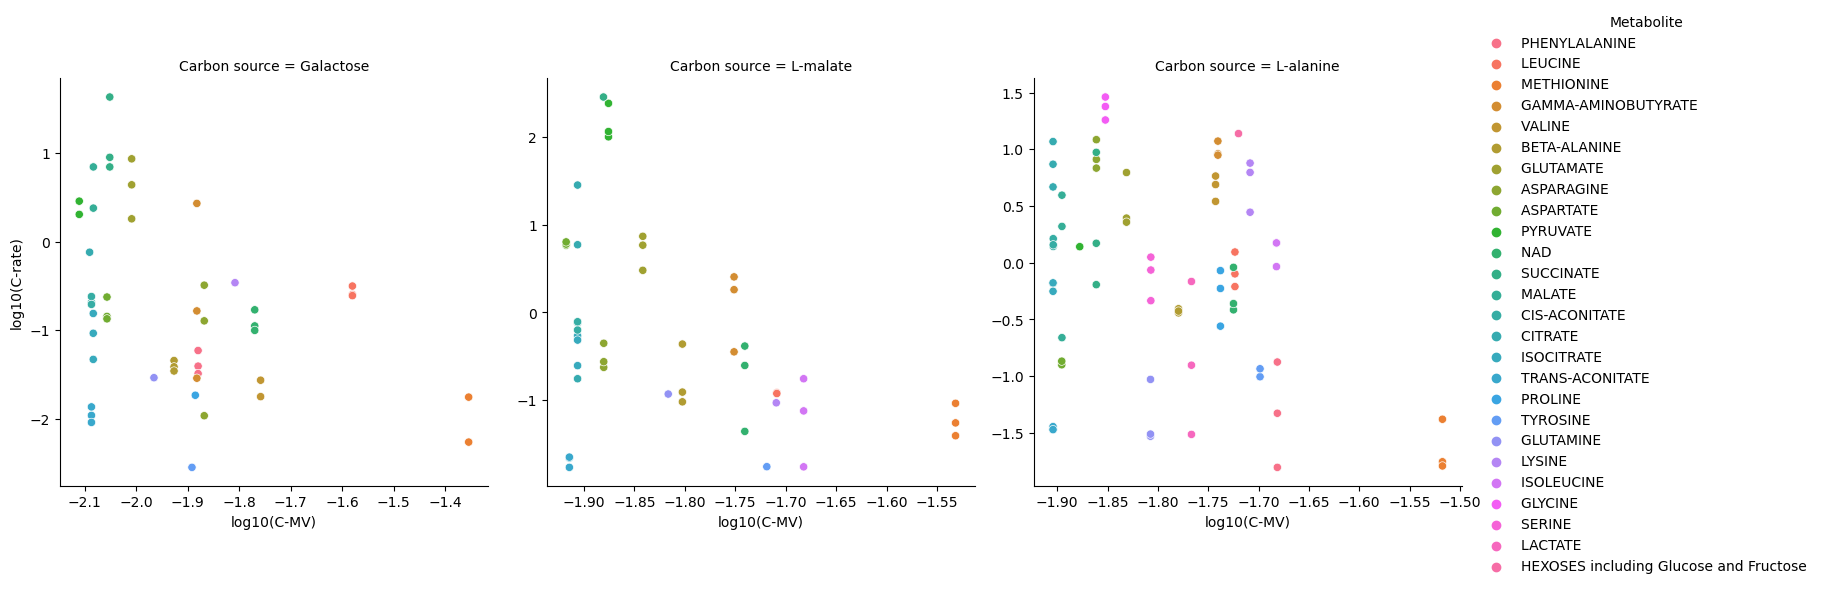

In [114]:
sns.relplot(data = df_rate_i1, y = 'log10(C-rate)', x = 'log10(C-MV)', col = 'Carbon source', facet_kws={'sharey': False, 'sharex': False}, hue = 'Metabolite')#
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


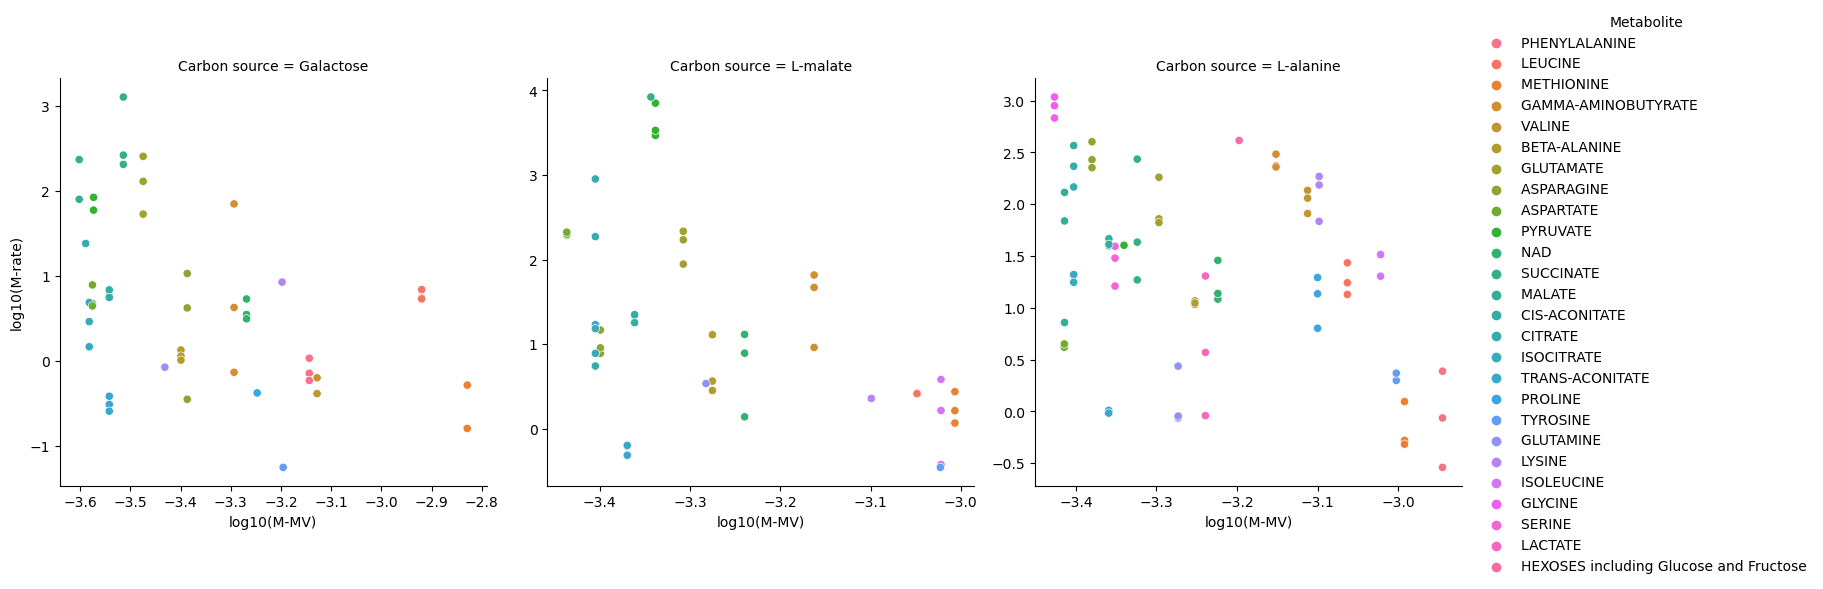

In [115]:
sns.relplot(data = df_rate_i1, y = 'log10(M-rate)', x = 'log10(M-MV)', col = 'Carbon source', facet_kws={'sharey': False, 'sharex': False}, hue = 'Metabolite')#
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


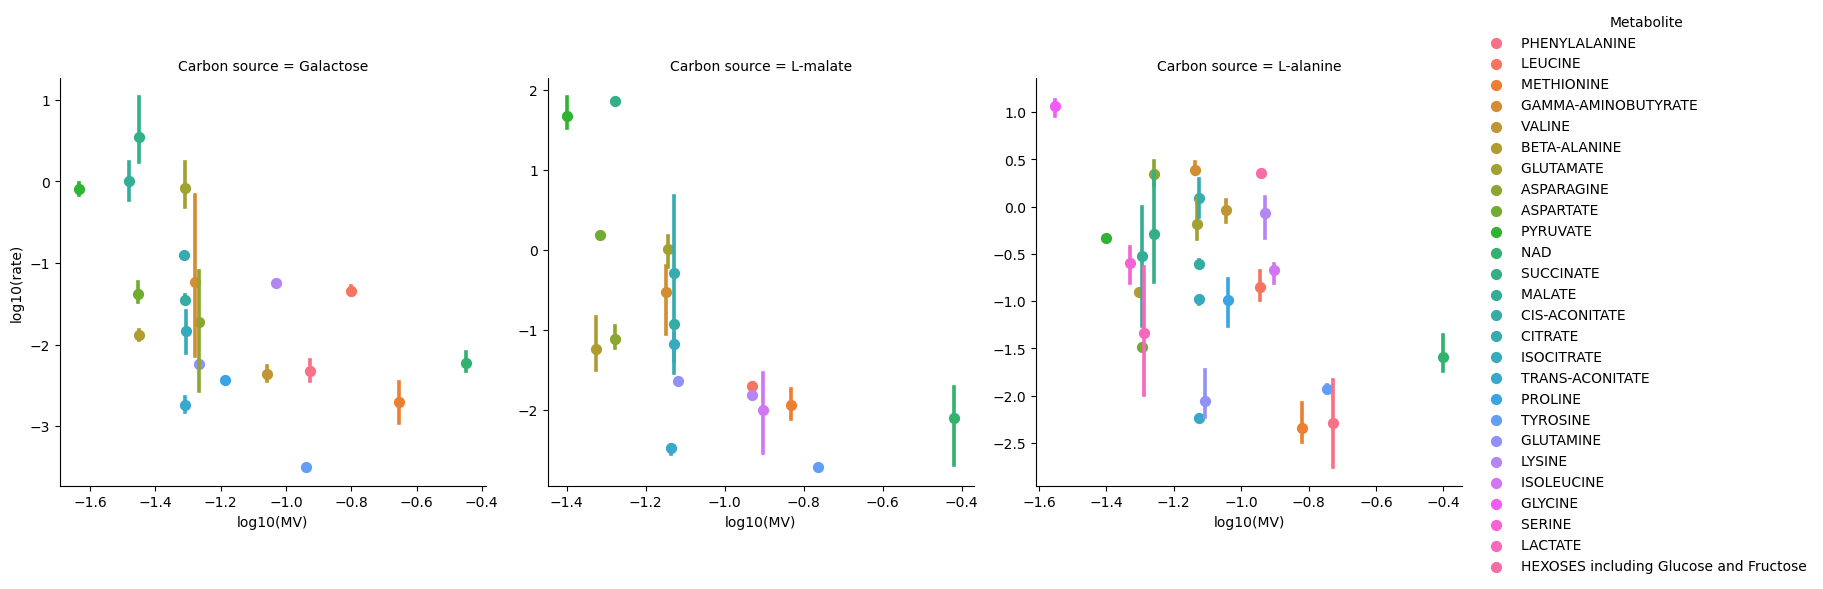

In [116]:
sns.lmplot(data = df_rate_i1, y = 'log10(rate)', x = 'log10(MV)', col = 'Carbon source', facet_kws={'sharey': False, 'sharex': False}, hue = 'Metabolite', x_estimator=np.mean)#
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


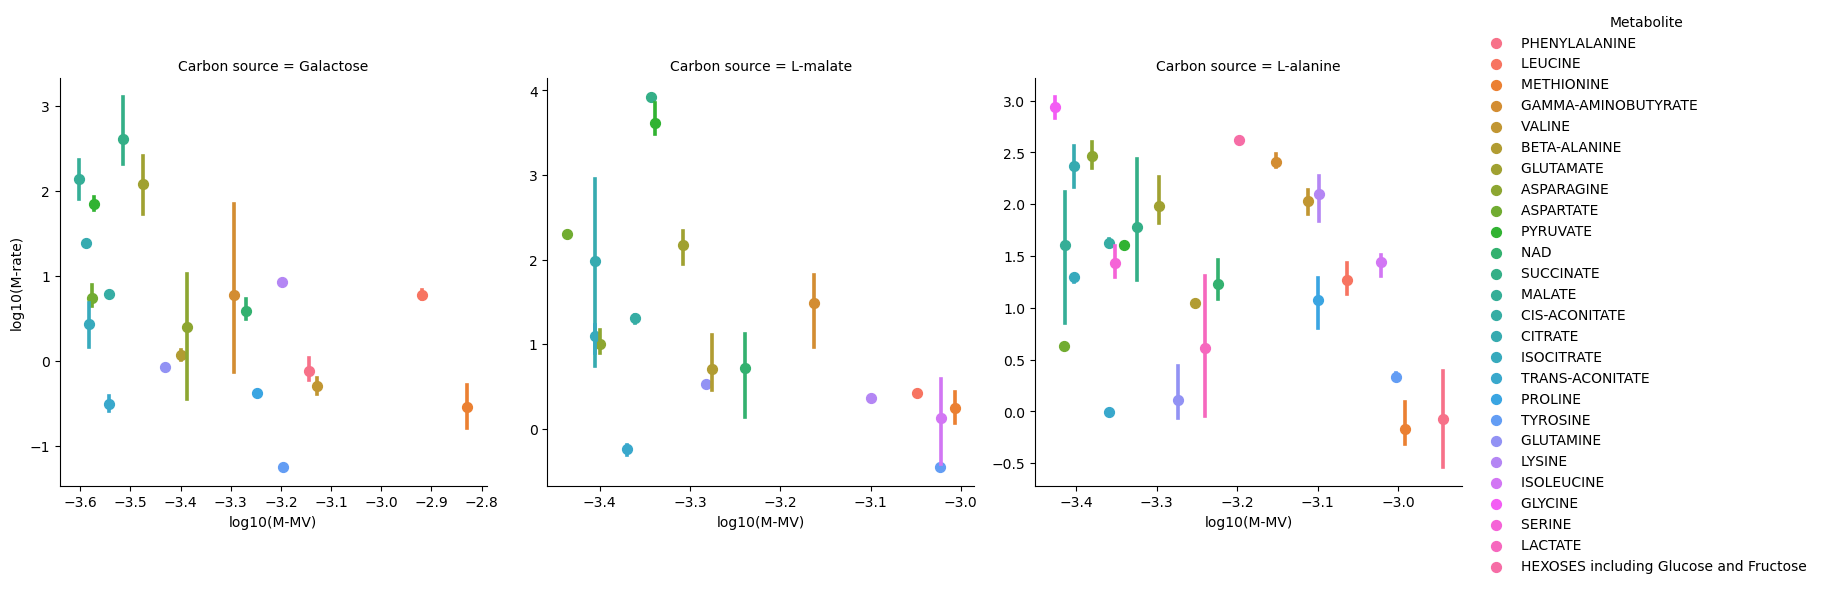

In [117]:
sns.lmplot(data = df_rate_i1, y = 'log10(M-rate)', x = 'log10(M-MV)', col = 'Carbon source', facet_kws={'sharey': False, 'sharex': False}, hue = 'Metabolite', x_estimator=np.mean)#
plt.show()

In [118]:
df_rate_i = average_rate_df.dropna()


In [119]:
df_rate_i.loc[df_rate_i['Carbon source'] == 'L-malate'].sort_values('Rate')

Carbon source                      Metabolite         Rate    Rate std
47      L-malate                         MALATE  -4941.312539  495.060784
46      L-malate                      SUCCINATE    -39.828979   42.946992
44      L-malate                        LACTATE     -2.090862    0.725564
52      L-malate                      GLUTARATE     -0.050781    0.077250
29      L-malate      GLUTARYLCARNITINE (C5-DC)     -0.022703    0.012622
35      L-malate                        PROLINE     -0.005936    0.001589
30      L-malate                  PHENYLALANINE     -0.004209    0.004062
38      L-malate                       CREATINE     -0.000031    0.000090
27      L-malate  SEBACOYL-L-CARNITINE (C10-DC)      0.001193    0.002343
51      L-malate                TRANS-ACONITATE      0.003335    0.000307
36      L-malate                 PIPECOLIC ACID      0.003742    0.000834
32      L-malate                     ISOLEUCINE      0.006784    0.011343
39      L-malate             ALPHA-AMINOADIPATE      0.006987    0.002373
45      L-malate                            NAD      0.009663    0.003805
33      L-malate                     METHIONINE      0.012511    0.002122
31      L-malate                        LEUCINE      0.019997    0.000716
37      L-malate                   BETA-ALANINE      0.039416    0.013458
50      L-malate                     ISOCITRATE      0.077537    0.024837
41      L-malate                     ASPARAGINE      0.083044    0.012958
48      L-malate                  CIS-ACONITATE      0.117969    0.007242
28      L-malate      DEOXYCARNITINE (DEOXY-C0)      0.176199    0.024937
34      L-malate            GAMMA-AMINOBUTYRATE      0.345390    0.116981
40      L-malate                      GLUTAMATE      1.075667    0.350295
42      L-malate                      ASPARTATE      1.478305    0.694045
49      L-malate                        CITRATE      2.315328    1.406755
43      L-malate                       PYRUVATE     53.809180   11.529560

In [126]:
for cs in df_rate_i['Carbon source'].unique():
    idx = df_rate_i1['Carbon source'] == cs
    pcorr, ppval = st.pearsonr(df_rate_i1.loc[idx, 'log10(rate)'], df_rate_i1.loc[idx, 'log10(MV)'])
    scorr, spval = st.spearmanr(df_rate_i1.loc[idx, 'log10(rate)'], df_rate_i1.loc[idx, 'log10(MV)'])
    print(cs, pcorr, ppval, scorr, spval)

Galactose -0.5067308634373845 0.00020293507163259193 -0.543169989749524 5.51397731507552e-05
L-malate -0.6213148574501375 5.251331302680746e-06 -0.715809323666751 3.2569907531465324e-08
L-alanine -0.4938653969441704 1.0408429835321515e-05 -0.4238710061828487 0.0002070408772579544


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


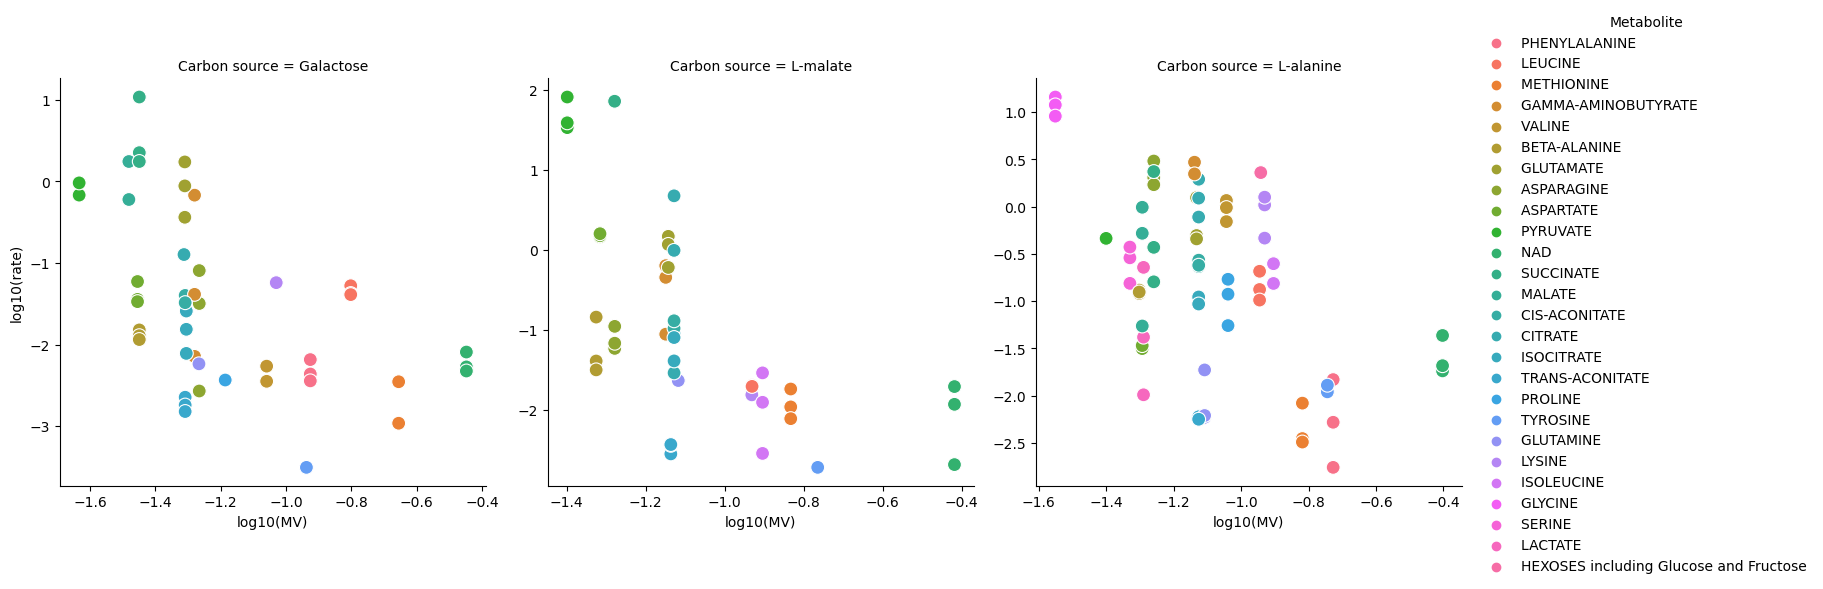

In [128]:
sns.relplot(data = df_rate_i1, y = 'log10(rate)', x = 'log10(MV)', col = 'Carbon source', facet_kws={'sharey': False, 'sharex': False}, hue = 'Metabolite', s = 100)#
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


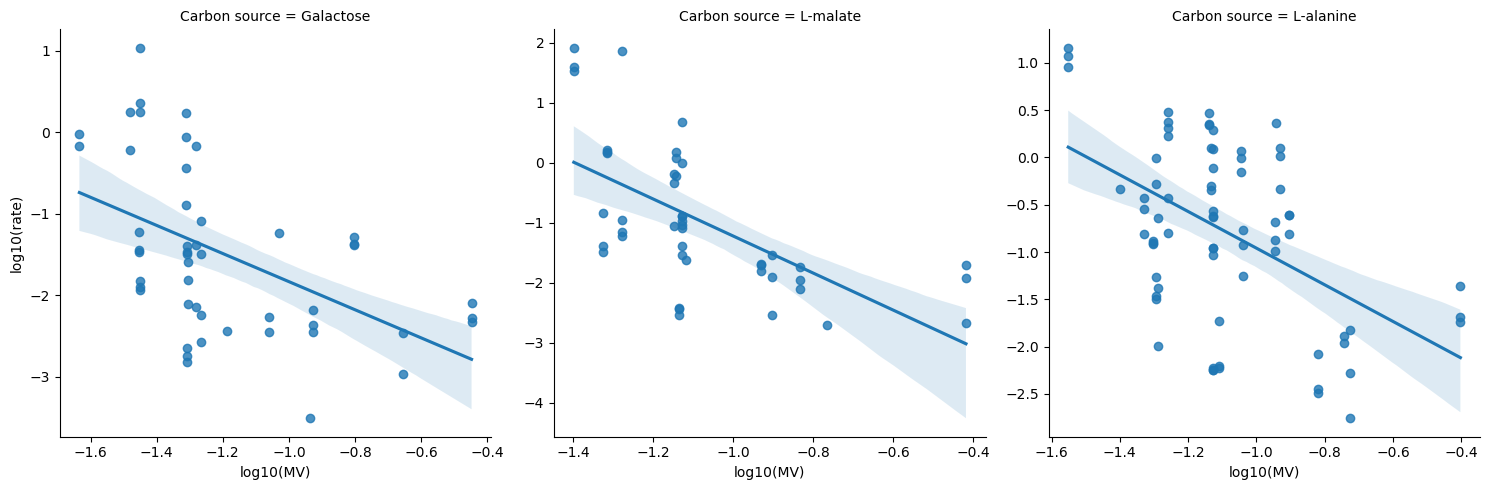

In [129]:
sns.lmplot(data = df_rate_i1, y = 'log10(rate)', x = 'log10(MV)', col = 'Carbon source', facet_kws={'sharey': False, 'sharex': False})#
plt.show()

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


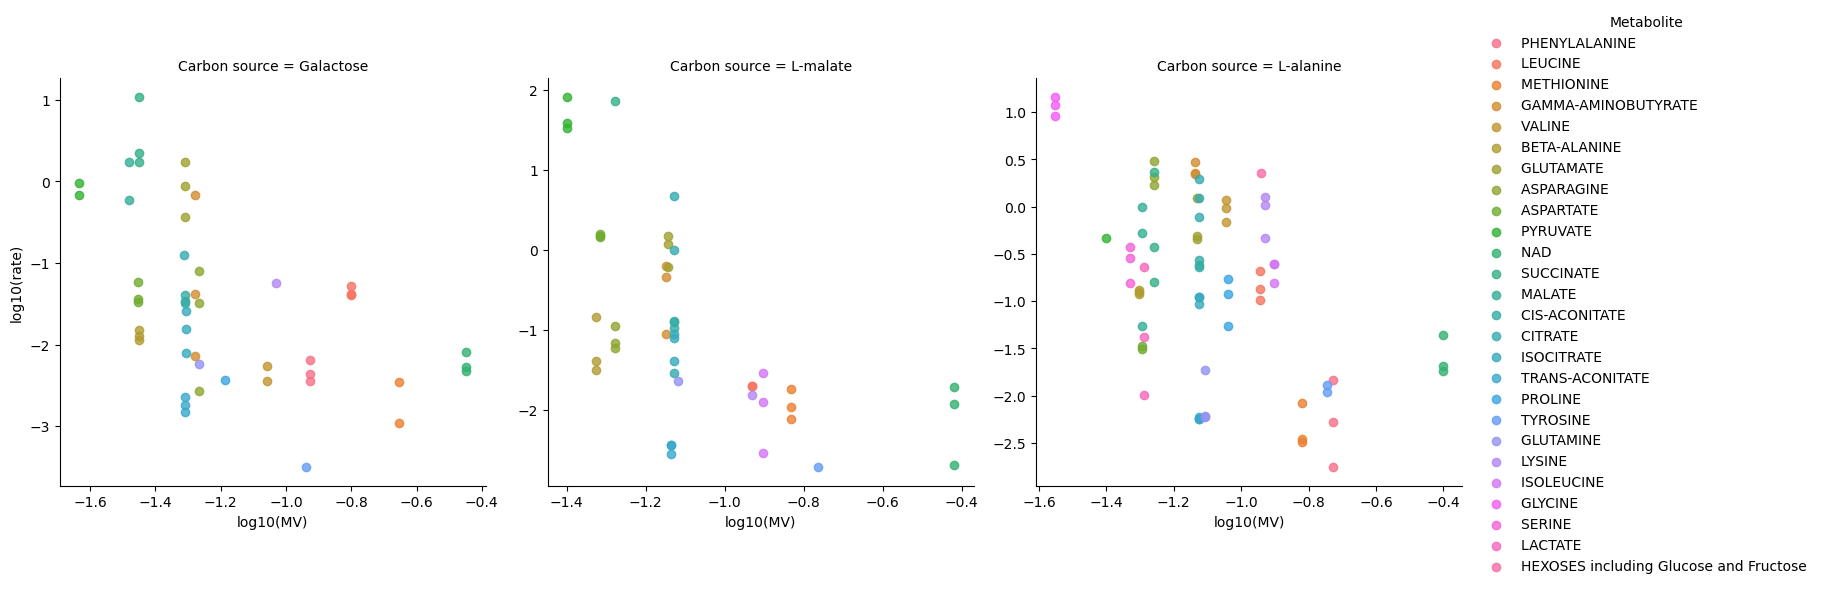

In [179]:
l = sns.lmplot(data = df_rate_i1, y = 'log10(rate)', x = 'log10(MV)', col = 'Carbon source', facet_kws={'sharey': False, 'sharex': False}, hue = 'Metabolite')#
plt.show()

In [196]:
import matplotlib

In [198]:
color_dict = {}
for x in l.axes[0][0].get_children():
    if type(x) == matplotlib.collections.PathCollection:
        color_dict[x.get_label().strip()] = x.get_facecolor()
            

In [146]:
dfl['Metabolite'] = dfl['Metabolite'].str.strip()

In [164]:
control_df.columns

Index(['Class 1', 'SEBACOYL-L-CARNITINE (C10-DC) ',
       'DEOXYCARNITINE (DEOXY-C0) ', 'GLUTARYLCARNITINE (C5-DC) ',
       'PHENYLALANINE ', 'LEUCINE ', 'ISOLEUCINE ', 'METHIONINE ',
       'GAMMA-AMINOBUTYRATE ', 'PROLINE ', 'TYROSINE ', 'VALINE ',
       'PIPECOLIC ACID ', 'ALPHA-AMINOBUTYRATE ', 'BETA-ALANINE ', 'ALANINE ',
       'CREATINE ', 'ALPHA-AMINOADIPATE ', 'GLYCINE ', 'GLUTAMINE ',
       'GLUTAMATE ', 'SERINE ', 'ASPARAGINE ', 'ASPARTATE ', 'LYSINE ',
       'PYRUVATE ', 'LACTATE ', 'HEXOSES including Glucose and Fructose ',
       'NAD ', 'GLUTARATE ', 'SUCCINATE ', 'MALATE ', 'CIS-ACONITATE ',
       'CITRATE ', 'ISOCITRATE ', 'TRANS-ACONITATE '],
      dtype='object')

In [174]:
data = []
carbon_source = 'Galactose'
timepoint = 'T3'

mean_medium_conc = control_df.loc[control_df['Class 1']==carbon_source].mean(numeric_only=True)
mean_medium_conc.index = [x.strip() for x in mean_medium_conc.index]
mean_medium_conc.fillna(0, inplace = True)

for met, bigg_id in mapping_dict.items():
    if not isinstance(bigg_id, str):
        continue
    idx = (dfl['Carbon source'] == carbon_source) & (dfl['Metabolite'] == met) & (dfl.Timepoint == 3)
    conc = dfl.loc[idx, 'Concentration'].values
    mmci = mean_medium_conc[met]
    for x in conc:
        dx = x-mmci
        # if x> 1e3:
        #     continue
        if dx < 0:
            continue
        if not np.isnan(x):
            data.append([met,dx, -sp_dict[carbon_source][f'{bigg_id}_c']])

In [175]:
dfi = pd.DataFrame(data, columns = ['Metabolite', 'Concentration', 'Metabolite value'])

In [176]:
dfi['log10(Concentration)'] = np.log10(dfi['Concentration'])
dfi['log10(mv)'] = np.log10(dfi['Metabolite value'])


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


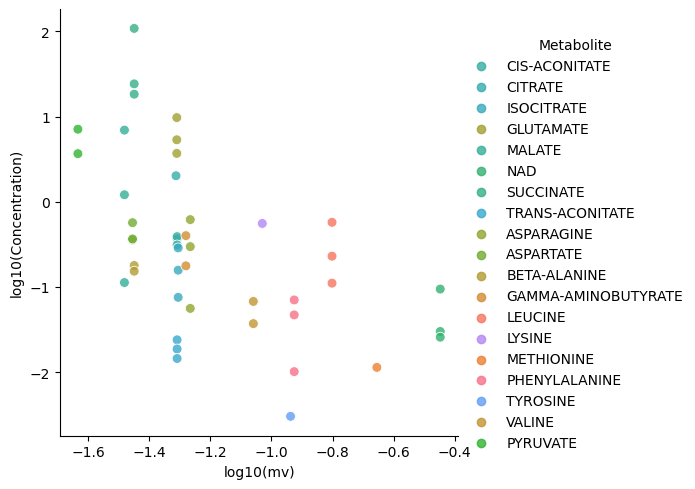

In [207]:
sns.relplot(data = dfi, x = 'log10(mv)', y = 'log10(Concentration)', hue = 'Metabolite', palette=color_dict, s = 50)
plt.show()

In [178]:
print(st.pearsonr(dfi['log10(mv)'], dfi['log10(Concentration)']))
print(st.spearmanr(dfi['log10(mv)'], dfi['log10(Concentration)']))

PearsonRResult(statistic=-0.5491805856100733, pvalue=9.356484017275736e-05)
SignificanceResult(statistic=-0.5866990728875005, pvalue=2.2793230809106575e-05)
